<div style="text-align:center"> 
        <strong style="font-size:30px;"> <br> Machine Learning : <br>  Classification de v√™tements </strong> 
    <br><br>
    <strong style="font-size:20px;">Jo√´l Hamilcaro & Jie Tu
    </strong> 
</div>


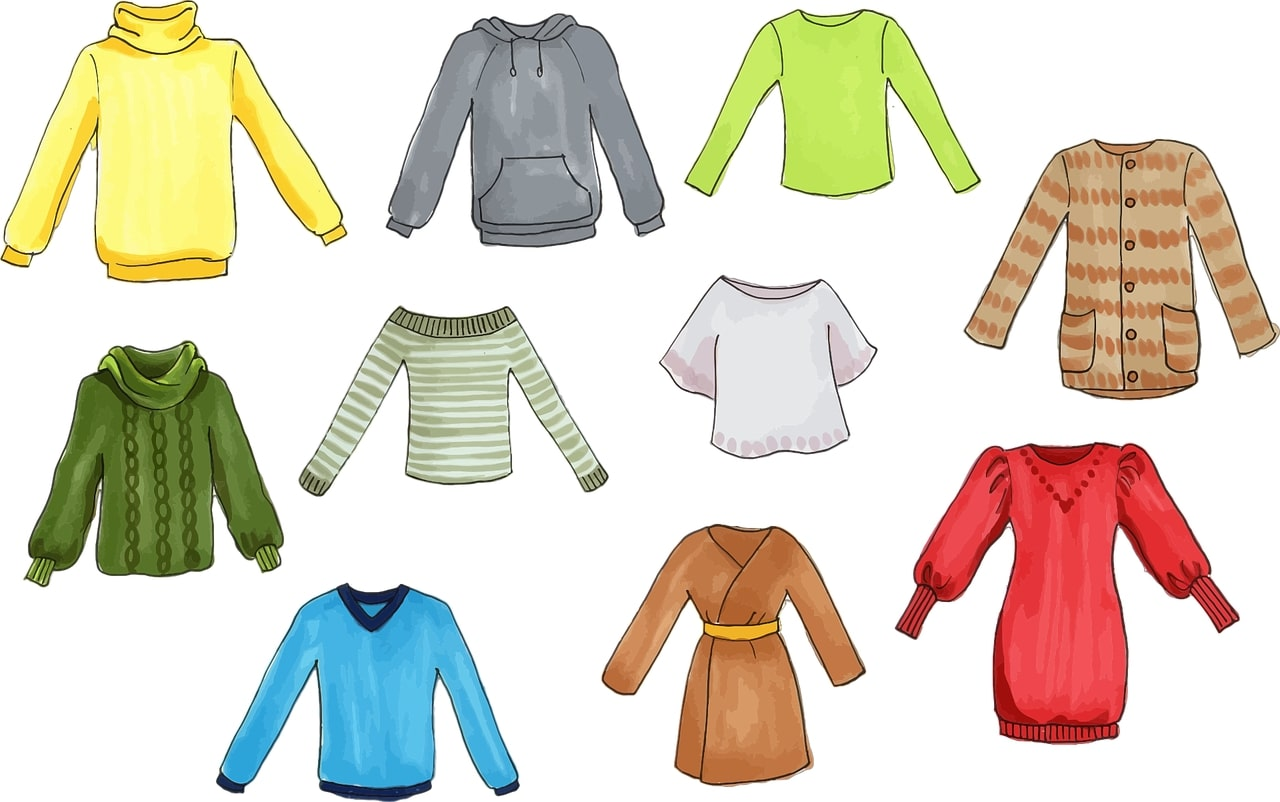

<div style="text-align:right;font-style:italic">
    Dessins de v√™tements (Source : Pixabay free Image)
</div>

# Introduction

Notre objectif est de programmer un r√©seau de neurones artificiel qui, √† partir d'une image de v√™tement, est capable de pr√©dire √† quelle classe appartient ce v√™tement (t-shirt, pantalon, robe, ...).

Pour cela, nous allons utiliser le jeu de donn√©e `fashion_mnist`, de l'API `tensorflow.keras`. Ici, les v√™tements appartiennent √† l'une des dix classes suivantes : 

- üëï T-shirt/Haut 
- üëñ Pantalon 
- üß• Pull-over
- üëó Robe
- ü•º Manteau
- üë° Sandale
- üëö Chemise
- üëü Sneaker
- üëú Sac
- ü•æ Botte

**Formalisation du probl√®me :**

Pour chaque individu ùëñ de notre jeu de donn√©e, on a une image $x_i$ et un label $y_i \in \{0,1,2,3,4,5,6,7,8,9\}$ correspondant √† une classe de v√™tement.

Probl√®me : √âtant donn√© une image $x$ on veut pr√©dire le label $y$.

Il s'agit d'un probl√®me de classification multi-classes.

# Param√©trage de l'environnement 

Dans un premier temps, nous devons configurer ce notebook dans le cas o√π il serait ex√©cut√© dans `google colab`. Cela nous permettra d'avoir acc√®s √† certaines biblioth√®ques (non incluses par d√©faut), et d'avoir acc√®s √† un espace de stockage (pour sauvegarder et charger nos futurs mod√®les).

In [1]:
# Mount drive storage in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install keras_tuner

# Importation des librairies n√©cessaires

On importe ici toutes les librairies qui nous seront n√©cessaires par la suite. De plus, on d√©finit les constantes de notre programme.

In [2]:
# Files Read/Write
import pickle as pkl
import os
from PIL import Image

# Math/Calculation
import numpy as np
from numpy.random import seed
import random

# Visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning 
import tensorflow as tf
from tensorflow.keras import utils, losses, optimizers, backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, \
    Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Activation
from tensorflow.image \
    import resize_with_crop_or_pad, pad_to_bounding_box, \
            adjust_contrast, adjust_gamma
from keras.utils.vis_utils import plot_model
import keras_tuner as kt

# Constants
COLORS_3 = ["#18CAE6","#53117F","#366EB3"]
COLORS_5 = ['#00429d', '#5d92bb', '#90ee90', '#d66f64', '#93003a']
FILE_PATH = "drive/MyDrive/DM2_fashion_mnist/"
IMG_PATH = FILE_PATH+"img/"
NB_CLASSES = 10

# Chargement des donn√©es

On charge maintenant le jeu de donn√©es `fashion_mnist`, de l'API `tensorflow.keras`. Il est constitu√© de donn√©es pour d'entrainement (pour entrainer nos mod√®les), et de donn√©es test (pour l'√©valuation des mod√®les).

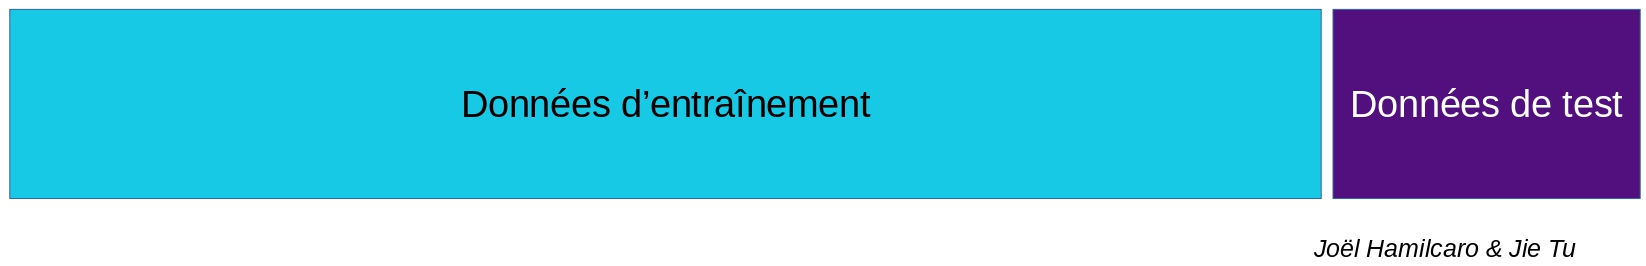

In [3]:
(train_images, train_labels) , (test_images, test_labels) = \
    fashion_mnist.load_data()

# Exploration des donn√©es

## Aper√ßu rapide des donn√©es

Dans notre jeu de donn√©es, les labels prennent des valeurs dans l'ensemble $\{0,1,2,3,4,5,6,7,8,9\}$. La correspondance entre la valeur num√©rique du label est le nom d'une classe de v√™tements est d√©finie dans le tableau suivant :

| Label number | Label name  |
|--------------|-------------|
| 0	           | T-shirt/top |
| 1	           | Trouser     |
| 2	           | Pullover    |
| 3	           | Dress       |
| 4	           | Coat        |
| 5	           | Sandal      |
| 6	           | Shirt       |
| 7	           | Sneaker     |
| 8	           | Bag         |
| 9	           | Ankle boot  |

On va tout d'abord cr√©√© un dictionnaire qui associe la valeur num√©rique du label √† la classe de v√™tements. Ce dictionnaire nous servira √† de nombreuses reprises pour les visualisations.

In [4]:
# label_dict[i] -> Name of i-th label
label_dict = {
    0 : "T-shirt",
    1 : "Trouser",
    2 : "Pull",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Boot"
}

Dans un second temps, on observe un exemple d'image $x_i$ parmi les donn√©es d'entrainement. Une image est encod√©e dans une matrice √† coefficient dans $\{0,...,255\}$. Chaque coefficient repr√©sente l'intensit√© de gris d'un pixel.

In [5]:
def print_title(title) :
    """
    
    Display the string in a box (in order to display a headline)
    
    Parameters
    ----------
    title : the string to print
    
    """
    border = '+'+75*'-'+'+'
    print('\n'+border)
    print('¬¶'+(" "+title+" ").center(75, '~')+'¬¶')
    print(border+'\n')
    return 


def print_image_to_matrix(i,images) : 
    """
    
    Print the image in a matrix
    
    Parameters
    ----------
    i : 
        index of the image to print
    images : 
        numpy.ndarray of images 
        (same format as train_images from fashion_mnist)
    
    """
    res = images[i].reshape(images.shape[1], images.shape[2])
    res = np.round(res,1)
    res = np.array2string(res, max_line_width=200)
    print(res)
    return 

def img_to_plt(i, images, cmap='gray_r') :
    """
    
    Returns a plot of the image
    
    Parameters
    ----------
    i : 
        index of the image to print
    images : 
        numpy.ndarray of images 
        (same format as train_images from fashion_mnist)
    cmap : 
        color map (default : gray_r)
        
    Returns
    ----------
    matplotlib.pyplot
    
    """
    plt.imshow(images[i].reshape(28, 28), cmap=cmap)
    return plt


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~ Encodage des images ~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Type de l'image (matrice) : <class 'numpy.ndarray'>
Type des pixels (coefficients de la matrice) : uint8

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Exemple d'encodage d'une image ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

[[  0   0   0   0   0   1   0   0   0   0  41 188 103  54  48  43  87 168 133  16   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0  49 136 219 216 228 236 255 255 255 255 217 215 254 231 160  45   0   0   0   0   0]
 [  0   0   0   0   0  14 176 222 224 212 203 198 196 200 215 204 202 201 201 201 209 218 224 164   0   0   0   0]
 [  0   0   0   0   0 188 219 200 198 202 198 199 199 201 196 198 198 200 

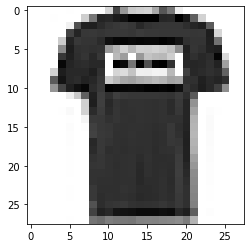

In [6]:
print_title("Encodage des images")
print("Type de l'image (matrice) :",type(train_images))
print("Type des pixels (coefficients de la matrice) :", train_images.dtype)

(print_title("Exemple d'encodage d'une image"))
print_image_to_matrix(1,train_images)  

(print_title("Affichage de l'image correspondante"))
img_to_plt(1,train_images).show()

On peut voir que nous avons 60000 images dans notre jeu d'entra√Ænement. Elles sont encod√©es dans des matrices de taille $28 \times 28$ :

In [7]:
print_title("Forme des donn√©es d'entra√Ænement")
print(train_images.shape)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~ Forme des donn√©es d'entra√Ænement ~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

(60000, 28, 28)


<hr> On peut observer un √©chantillon des donn√©es d'entra√Ænement.

In [8]:
def plt_sample(n_row, n_col, images, labels, 
                cmap='gray_r', random_state=None , head_0_tail_1=-1 ) :
    """
    
    Display several images and their labels
    
    Parameters
    ----------
    n_row : 
        number of images in a column (number of rows)
    n_col : 
        number of images in a row (number of columns)
        
    images : 
        numpy.ndarray of images 
        (same format as train_images from fashion_mnist)
    
    labels : 
        numpy.ndarray of labels corresponding to the images
        (same format as train_labels from fashion_mnist)
    
    cmap : 
        color map (default : gray_r)
     
    random_state :
        if not None, fix the seed for reproductibility
        
    head_0_tail_1 :
        0 : display the first images (head) of the ndarray
        1 : display the last images (tail) of the ndarray
        other value : display random images of the ndarray
        
    Returns
    ----------
    matplotlib.pyplot
    """ 
    if random_state is not None : seed(random_state)
    plt.figure(figsize=(10, 5))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        if head_0_tail_1 == 0 : idx = i
        elif head_0_tail_1 == 1 : idx = len(images)-i-1
        else : idx = np.random.randint(0,len(images))
        plt.imshow(images[idx].reshape(28, 28), cmap=cmap)
        txt = plt.text(0, 40, 
                       f'  {label_dict[labels[idx]]}'.upper(),
                       c=COLORS_3[0],
                       size="large", 
                       weight="heavy")
        plt.subplots_adjust(left=None, bottom=None, 
                            right=None, top=None, 
                            wspace=None, hspace=None)
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, 
                                                     foreground='black')])
        plt.axis("off")
    plt.tight_layout()
    return plt


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~ Aper√ßu d'un √©chantillon des donn√©es ~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



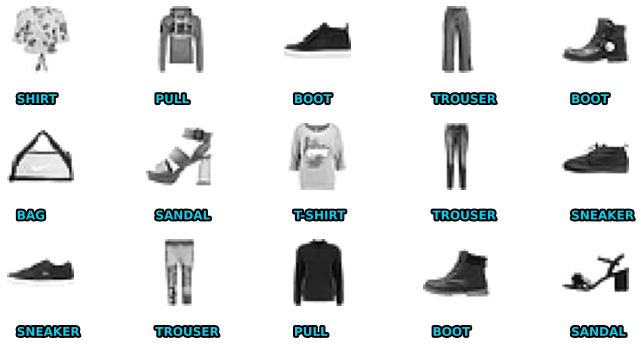

In [9]:
print_title("Aper√ßu d'un √©chantillon des donn√©es")
plt_sample(n_row=3, n_col=5,
           images=train_images,
           labels=train_labels,
           random_state=12,
           head_0_tail_1=-1).show()

## Distribution des donn√©es

On va d√©sormais √©tudier la distribution des donn√©es.

On calcule, pour chaque label, sa proportion dans le jeux d'entra√Ænement et le jeu de test.

In [10]:
def sty(df,test) :
    """
    
    Adds colors to the dataframe 
    (the colors depends of the parameter named "test")
    
    Parameters
    ----------
    df : 
        A Panda dataframe
    test : 
        A boolean value (determines the color)
        
    Returns
    ----------
    pandas.io.formats.style.Styler
    
    """
    return df.style.set_properties(**{
        'background-color': COLORS_3[test],
        'color': ('white' if test else 'black') })


def df_labels_distribution(images, labels) :
    """
    
    Create a dataframe with distributions of labels
    
    Parameters
    ----------
    images : 
        numpy.ndarray of images 
        (same format as train_images from fashion_mnist)
    
    labels : 
        numpy.ndarray of labels corresponding to the images
        (same format as train_labels from fashion_mnist)
        
    Returns
    ----------
    pandas.core.frame.DataFrame
    
    """
    df = pd.DataFrame()            
    df['Label'] = labels
    df = df.groupby(['Label']).size().reset_index(name='Nombre')
    df['Proportion'] = df.Nombre/df.Nombre.sum()
    df['Nom du label'] = list(map(lambda x : label_dict[x] , df.Label))
    
    return df

print_title("Distribution des labels dans le jeu d'entrainement")
df_train_prop = df_labels_distribution(train_images,train_labels)
display( sty(df_train_prop, test=False) )

print_title("Distribution des labels dans le jeu de test")
df_test_prop = df_labels_distribution(test_images,test_labels)
display( sty(df_test_prop, test=True) )


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~ Distribution des labels dans le jeu d'entrainement ~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+




+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~ Distribution des labels dans le jeu de test ~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



In [11]:
def plt_distribution(df_train,df_test,valid=False) :
    """
    
    Create a bar plot of distributions of train and test labels
    
    Parameters
    ----------
    df_train : 
        panda dataframe of distribution with a column named "Proportion"
        and a columns named "Nom du label"
    df_test : 
        panda dataframe of distribution with a column named "Proportion"
        and a columns named "Nom du label"
    valid :
        if True, "test" is replaced by "valid"
    Returns
    ----------
    matplotlib.pyplot
    
    """
    if valid : 
        color = COLORS_3[2]
    else :
        color = COLORS_3[1]
    colors = [COLORS_3[0],color]
    df = pd.DataFrame(np.c_[df_train.Proportion,df_test.Proportion], 
                      index=df_train["Nom du label"])
    df.plot.bar(figsize=(15,5),color=colors)
    plt.legend(["Train","Valid" if valid else "Test"],
               title="Donn√©es", loc=4, shadow=True)
    plt.ylabel("Proportion")
    plt.title("Comparaison des distributions")
    return plt

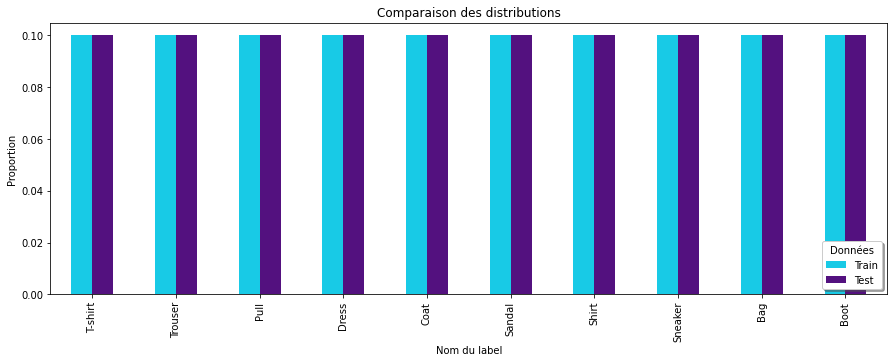

In [12]:
plt_distribution(df_train_prop,df_test_prop).show()

<hr><div class='alert alert-info' role='alert'><p><b>
Les labels sont distribu√©s de mani√®re parfaitement uniforme, √† la fois dans le jeu d'entra√Ænement et dans le jeu de test.  
</b></p></div> 

# Pr√©paration des donn√©es

On va maintenant pr√©parer nos donn√©es avant qu'elles ne soient utilis√©es pour l'entra√Ænement de notre r√©seau de neurones artificiels.

## Valeurs manquantes

Tout d'abord, on observe si les donn√©es pr√©sentent des valeurs manquantes. Si c'est le cas, il faudra les traiter. Pour v√©rifier s'il y a des valeurs manquantes, on va calculer une valeur bool√©enne (qui vaudra `True` s'il y a au moins une valeur manquante). On affiche ci-dessous les r√©sultats obtenus.

In [13]:
def print_none(tab) : 
    """
    
    Print a text that describes if there are any missing values in tab
    
    Parameters
    ----------
    tab : 
        the array to check
    
    """
    if (train_labels == None).any() :
        print("Il y a des valeurs manquantes.")
    else : 
        print("Il n'y a aucune valeur manquante.")
    return

In [14]:
print_title("Images du jeu d'entra√Ænement :")
print_none( train_images )
print_title("Labels du jeu d'entra√Ænement :")
print_none( train_labels )
print_title("Labels du jeu de test :")
print_none( test_labels )
print_title("Images du jeu de test :")
print_none( test_images )


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Images du jeu d'entra√Ænement : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Il n'y a aucune valeur manquante.

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Labels du jeu d'entra√Ænement : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Il n'y a aucune valeur manquante.

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Labels du jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Il n'y a aucune valeur manquante.

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Images du jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+----------------------

<hr><div class='alert alert-info' role='alert'><p><b>Il n'y a aucune valeur manquante dans toutes nos donn√©es.</b></p></div>

## Encodage One-Hot des labels

On va maintenant s'interesser au typage des labels.

In [15]:
print_title("Typage des labels :")
print(train_labels[0].dtype)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~ Typage des labels : ~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

uint8


On peut voir que les labels sont repr√©sent√©s par des entiers `unint8`. On va les convertir en variable cat√©gorielles afin de se d√©barrasser de potentiels bruits lors de l'apprentissage (e.g. relation d'ordre des entiers). Pour cela, on va r√©aliser un encodage One-Hot.

**Encodage One-Hot :**

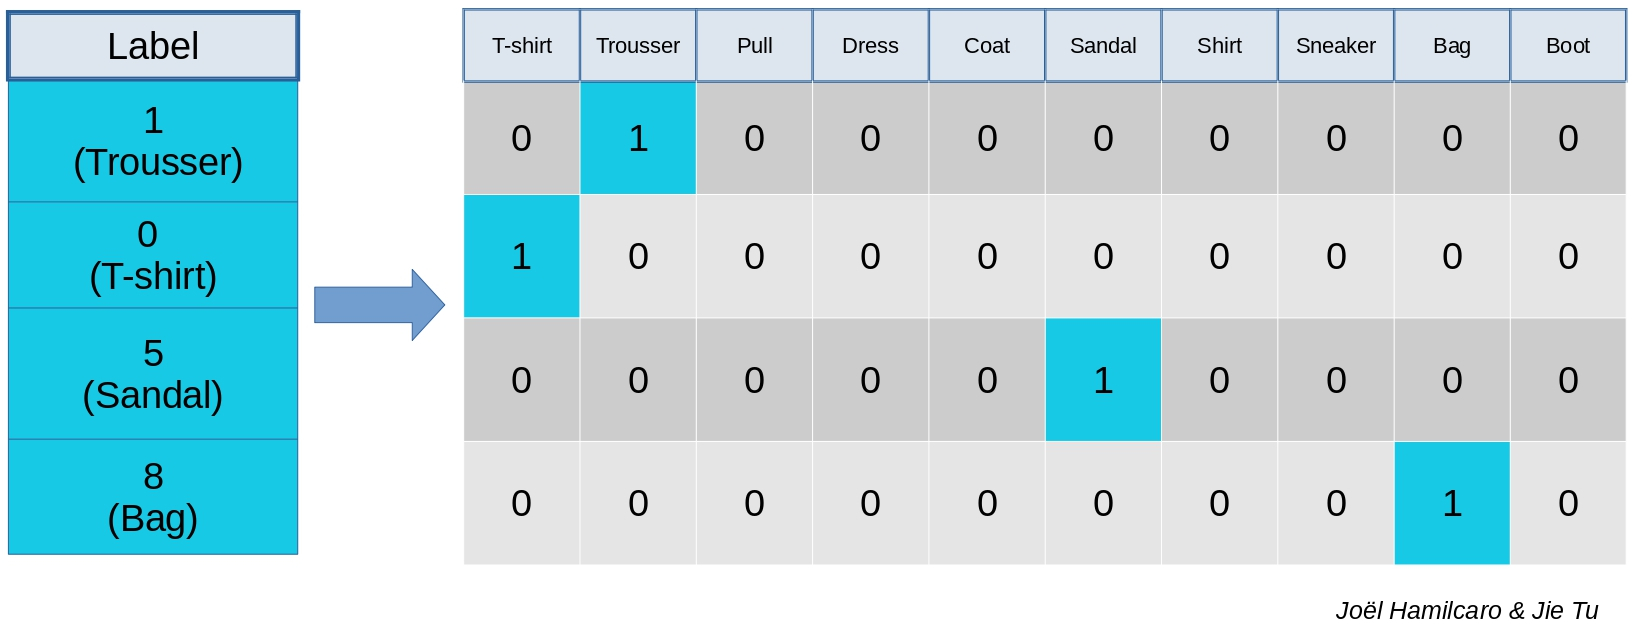

In [16]:
def sty_max(df,test=False, axis=1) :
    """
    
    Adds colors to the maximum box of each row of the dataframe 
    (the colors depends of the parameter named "test")
    
    Parameters
    ----------
    df : 
        A Panda dataframe
    test : 
        A boolean value (determines the color)
        
    Returns
    ----------
    pandas.io.formats.style.Styler
    
    """
    return df.style.highlight_max(axis=axis, color=COLORS_3[test])        

def OHE(labels) :
    """
    
    Return a One-Hot encoded array from a array of labels
    
    Parameters
    ----------
    labels : 
        Array of labels
     
    Returns
    ----------
    numpy.ndarray
    
    """
    labels = utils.to_categorical(labels,NB_CLASSES)
    return labels

In [17]:
print_title("Labels avant encodage One-Hot")
display(sty_max(pd.DataFrame(train_labels).head(5)))
print_title("Labels apr√®s encodage One-Hot")
display(sty_max(pd.DataFrame(OHE(train_labels)).head(5)))


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Labels avant encodage One-Hot ~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+




+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Labels apr√®s encodage One-Hot ~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



## Normalisation des images

On a pu voir dans la section "*Exploration des donn√©es*" que les images √©taient des matrices (`numpy.ndarray`) √† coefficients entre 0 et 255 (`uint8`). Ce type est pertinent pour encoder les intensit√©s de gris. Cependant, nous allons les modifier en type `float32` afin de pouvoir normaliser nos images. Apr√®s normalisation, les valeurs des coefficients de la matrice seront comprises entre 0 et 1.

**Normalisation :**

Pour chaque individu $i \in I$, la $k$-√®me feature (not√©e $X_{i,k}$) sera remplac√©e par la valeur  : 

$$X_{i,k}^{'} = \dfrac{X_{i,k}- \min_{ j \in I }{( X_{j,k} )}  }{ \max_{ j \in I }{( X_{j,k} )} - \min_{ j \in I }{( X_{j,k} )}  }$$

Ici, comme il s'agit de l'intensit√© de gris de chaque pixel de l'image (repr√©sent√© par un nombre entier entre 0 et 255). Il s'agit donc de r√©aliser l'op√©ration : 

$$X_{i,k}^{'} = \dfrac{X_{i,k}- 0}{ 255 - 0 } = \dfrac{X_{i,k}}{ 255 } $$

In [18]:
def normalization(images,X_max=255,X_min=0) :
    """
    
    Return a array of normalized images
    
    Parameters
    ----------
    images : 
        Array of images
    X_max : 
        Maximum value of a pixel (default 255)
    X_min :
        Minimum value of a pixel (default 0)
     
    Returns
    ----------
    numpy.ndarray
    
    """
    images = images.astype('float')
    images = ( images - X_min ) / ( X_max - X_min ) 
    return images


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Image avant normalisation ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

[[  0   0   0   0   0   1   0   0   0   0  41 188 103  54  48  43  87 168 133  16   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0  49 136 219 216 228 236 255 255 255 255 217 215 254 231 160  45   0   0   0   0   0]
 [  0   0   0   0   0  14 176 222 224 212 203 198 196 200 215 204 202 201 201 201 209 218 224 164   0   0   0   0]
 [  0   0   0   0   0 188 219 200 198 202 198 199 199 201 196 198 198 200 200 200 200 201 200 225  41   0   0   0]
 [  0   0   0   0  51 219 199 203 203 212 238 248 250 245 249 246 247 252 248 235 207 203 203 222 140   0   0   0]
 [  0   0   0   0 116 226 206 204 207 204 101  75  47  73  48  50  45  51  63 113 222 202 206 220 224   0   0   0]
 [  0   0   0   0 200 222 209 203 215 200   0  70  98   0 103  59  68  7

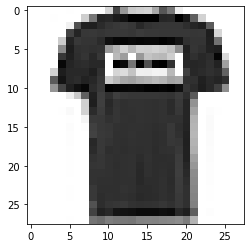

In [19]:
print_title("Image avant normalisation")
print_image_to_matrix(1,train_images)
print_title("Image apr√®s normalisation")
tmp = normalization(train_images)
print_image_to_matrix(1,tmp)
print_title("Image correspondante")
img_to_plt(1,train_images).show()

##¬†"Reshaping"

Il nous reste un dernier pr√©traitement √† r√©aliser. Nous allons changer le format des images afin qu'elles puissent √™tre accept√©es en entr√©e de notre r√©seau de neurones artificiels. Notre r√©seau de neurones prend en entr√©e des tenseurs. Comme chaque image est repr√©sent√©e par une matrice $28 \times 28$, nous allons les convertir en tenseur $ 28 \times 28 \times 1 $. 

In [20]:
def reshape(images):
    """
    
    Reshape images in order to be usable for keras neural network
    
    Parameters
    ----------
    images : 
        Array of images
     
    Returns
    ----------
    numpy.ndarray
    
    """
    image_data_format = K.image_data_format()
    if image_data_format == 'channels_first':
        return images.reshape((-1, 1, images.shape[1], images.shape[2]))
    else:
        return images.reshape((-1, images.shape[1], images.shape[2], 1))

def get_input_shape(images) :
    """
    
    Get the shape of images
    
    Parameters
    ----------
    images : 
        Array of images
     
    Returns
    ----------
    numpy.ndarray
    
    """
    image_data_format = K.image_data_format()
    if image_data_format == 'channels_first':
        return (1, images.shape[1], images.shape[2])
    else:
        return (images.shape[1], images.shape[2],1)
    


In [21]:
INPUT_SHAPE = get_input_shape(train_images)
print_title("Format avant \"Reshaping\"")
print("Ensemble des images d'entra√Ænement :", train_images.shape)
print_title("Format apr√®s \"Reshaping\"")
print("Ensemble des images d'entra√Ænement :", reshape(train_images).shape)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Format avant "Reshaping" ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Ensemble des images d'entra√Ænement : (60000, 28, 28)

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Format apr√®s "Reshaping" ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Ensemble des images d'entra√Ænement : (60000, 28, 28, 1)


## R√©sum√© 

On d√©finit enfin des fonctions qui permettront de r√©aliser toutes ces √©tapes de pr√©traitement (encodage One-Hot, normalisation, "reshaping").

In [22]:
def preprocess_images(images) :
    """
    
    Return preprocessed images 
    -> Normalization
    -> Reshaping
    
    Parameters
    ----------
    images : 
        Array of images
     
    Returns
    ----------
    numpy.ndarray
    
    """
    images = normalization(images)
    images = reshape(images)
    return images
    
def preprocess(images, labels) :
    """
    
    Return preprocessed images and labels
    
    Images
    -> Normalization
    -> Reshaping
    
    Labels
    -> One-Hot Encoding
    
    Parameters
    ----------
    images : 
        Array of images
    labels : 
        Array of corresponding labels
     
    Returns
    ----------
    numpy.ndarray , numpy.ndarray
    
    """
    labels = OHE(labels)
    images = preprocess_images(images)
    return images,labels

# Notre mod√®le de d√©part : "CNN par d√©faut"

Maintenant nous avons d√©fini nos fonctions de pr√©traitement, nous pouvons enfin d√©finir notre premier r√©seau de neurones artificiels. La premi√®re architecture que nous allons r√©aliser est celle du r√©seau neuronal convolutif sugg√©r√© par l'√©nonc√©. √Ä partir de maintenant, nous allons appeler cette architecture : "**Le mod√®le CNN par d√©faut**".

## Cr√©ation de l'architecture 

L'architecture sugg√©r√©e par l'√©nonc√©, que nous appelons "Mod√®le CNN par d√©faut" est la suivante : 

> - Couche de **convolution** √† $64$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **Max Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilit√© $0.25$
>
> - Couche de **convolution** √† $128$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **Max Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilit√© $0.25$
>
> - Couche de **convolution** √† $256$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **Max Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilit√© $0.25$
>
> - Couche **dense** √† $256$ neurones
> - Couche de **Dropout** avec probabilit√© $0.5$
> - Couche de perte avec activation **softmax**

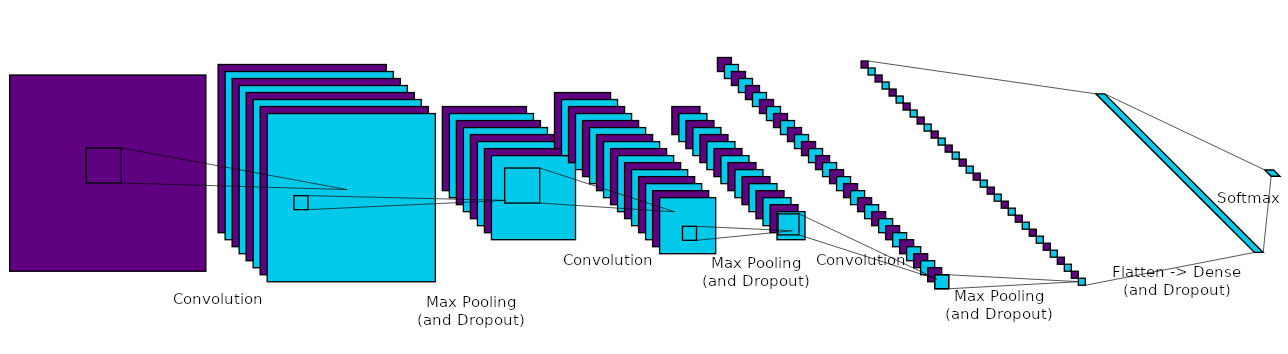

Au pr√©alable, on va d√©finir des fonctions qui vont nous permettre de sauvegarder nos mod√®les, et de les charger si besoin.

In [23]:
def save_model(model,history,name) :
    """
    
    Save the model and the history
    
    Parameters
    ----------
    name :
        name of the model
    model : 
        the model
    history : 
        history of the model
    
    """
    model.save(FILE_PATH+f'model_{name}.h5')
    if history != None :
        with open(FILE_PATH+f'history_{name}.pkl', 'wb') as f:
            pkl.dump(history.history, f)
    else : 
        with open(FILE_PATH+f'history_{name}.pkl', 'wb') as f:
            pkl.dump("0", f)

def my_load_model(name) :
    """
    
    Load the model and the history
    
    Parameters
    ----------
    name :
        name of the model
    
    Returns
    ----------
    model, history
    
    """
    model = load_model(FILE_PATH+f"model_{name}.h5")
    with open(FILE_PATH+f"history_{name}.pkl", "rb") as f:
        history = pkl.load(f)
    return model, history

def my_load_model_full(name) :
    """
    
    Load the model, epochs, accuracy, val_accuracy, loss and val_loss histories
    
    Parameters
    ----------
    name :
        name of the model
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss
    
    """
    model_cnn, history_cnn = my_load_model(name)
    epoch = np.arange(1,len(history_cnn["accuracy"])+1)
    accuracy = history_cnn["accuracy"]
    val_accuracy = history_cnn["val_accuracy"] 
    loss = history_cnn["loss"]
    val_loss = history_cnn["val_loss"] 
    return model_cnn, epoch, accuracy, val_accuracy, loss, val_loss

def model_exists(name) : 
    """
    Verify if the model exists in files
    
    Parameters
    ----------
    name :
        name of the model
    
    Returns
    ----------
    bool
    """
    return os.path.exists(FILE_PATH+f"model_{name}.h5") \
        and os.path.exists(FILE_PATH+f"history_{name}.pkl")

On d√©finit maintenant nos fonctions permettant de cr√©er le mod√®le CNN par d√©faut, et de l'entra√Æner.

In [24]:
def fit_NN(model, X_train, y_train, X_valid, y_valid, epochs=100, 
           verbose=0, early_stop=False, patience=3, batch_size=64):
    """
    
    Fit the model
    
    Parameters
    ----------
    model :
       the model
    X_train :
        images for training
    y_train : 
        label for labels
    X_valid :
        images for validation
    y_valid :
        labels for validation
    epochs :
        number of epochs (default 100)
    verbose :
        print details (default 0)
    early_stop :
        activate early stopping or not (default : False)
    patience :
        number of epochs before early stopping
    batch_size :
        size of the batchs (default 64)
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss
    
    """
    # Fix randomness for reproductibility
    tf.random.set_seed(75)
    seed(75)

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        validation_data=(X_valid, y_valid),
        callbacks = [tf.keras.callbacks.EarlyStopping(patience=patience)] \
            if early_stop else None
    ) 

    epoch = history.epoch
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"] 
    loss = history.history["loss"]
    val_loss = history.history["val_loss"] 

    return model, epoch, accuracy, val_accuracy, loss, val_loss, history

def create_default_CNN(name="", param_name=None, param_value=None) :
    """
    Create the default CNN model
    
    Parameters
    ----------
    name :
        name of the model
    param_name :
        name of the hyperparameter to test
    param_value :
        value of the hyperparameter to test
    
    Returns
    ----------
    model
    
    """
    # Fix randomness for reproductibility
    tf.random.set_seed(75) 
    seed(75)
    # If specified, Hyperparameters to test. Else, default values
    input_shape = INPUT_SHAPE
    units = param_value if param_name=="units" else 256
    kernel_size = param_value \
        if param_name=="kernel_size" else [(5,5),(5,5),(3,3)]
    filters = param_value if param_name=="filters" else [64,128,256]
    learning_rate = param_value if param_name=="learning_rate" else 0.0001 
    dropout_rate = param_value \
        if param_name=="dropout_rate" else [ 0.25 , 0.25, 0.25 , 0.5 ]
    pool_size = param_value if param_name=="pool_size" else (2,2)
    # Neural Network
    model_cnn = Sequential(name="DefaultCNN_"+name)
    model_cnn.add(Conv2D(filters[0], kernel_size=kernel_size[0],
                         activation='relu', input_shape=input_shape, 
                         name='Convolu_1'))
    model_cnn.add(MaxPooling2D(pool_size=pool_size, name='MaxPool_1'))
    model_cnn.add(Dropout(dropout_rate[0], name='Dropout_1'))
    model_cnn.add(Conv2D(filters[1], kernel_size=kernel_size[1], 
                         activation='relu', name='Convolu_2'))
    model_cnn.add(MaxPooling2D(pool_size=pool_size, name='MaxPool_2'))
    model_cnn.add(Dropout(dropout_rate[1], name='Dropout_2'))
    model_cnn.add(Conv2D(filters[2], kernel_size=kernel_size[2], 
                         activation='relu', name='Convolu_3'))
    model_cnn.add(MaxPooling2D(pool_size=pool_size, name='MaxPool_3'))
    model_cnn.add(Dropout(dropout_rate[2], name='Dropout_3'))
    model_cnn.add(Flatten(name='Flatten_1')) 
    model_cnn.add(Dense(units, activation='relu', name='Densely_1'))
    model_cnn.add(Dropout(dropout_rate[3], name='Dropout_4'))
    model_cnn.add(Dense(NB_CLASSES, activation='softmax', name='Softmax'))
    model_cnn.compile(loss=losses.categorical_crossentropy,
                    optimizer=optimizers.Adam(learning_rate=learning_rate),
                    metrics=['accuracy'])
    return model_cnn



def create_and_fit_CNN(X_train, y_train, X_valid, y_valid, 
                       epochs=100, name="", param_name=None, 
                       param_value=None, early_stop=False) :
    """
    Create the default CNN model and fit the model
    
    Parameters
    ----------
    X_train, y_train, X_valid, y_valid :
        train and valid datasets
    epochs : 
        number of epochs
    name :
        name of the model
    param_name :
        name of the hyperparameter to test
    param_value :
        value of the hyperparameter to test
    early_stop :
        if True, do early stopping
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss
    
    """
    print_title("Entrainement du r√©seau neuronal "+name)
    model_cnn = create_default_CNN(name=name,param_name=param_name,
                                 param_value=param_value)
    batch_size = param_value if param_name == "batch_size" else 64 
    return fit_NN(model_cnn,X_train, y_train,X_valid, y_valid,
                  epochs=epochs,verbose=1, early_stop=early_stop, 
                  batch_size=batch_size)

Enfin, on d√©finit des fonctions de visualisation (affichage des hyperparam√®tres du mod√®le, courbe d'apprentissage).

In [25]:
def plot_acc_loss(epochs, acc, val_acc, loss, val_loss, title='', 
                  multiple=False, labels=None, training=True) :
    """
    Plot the loss and accuracy curves
    
    Parameters
    ----------
    epochs :
        list of epochs
    acc :
        list of accuracies
    val_acc :
        list of validation accuracies
    loss :
        list of losses
    val_loss :
        list of validation losses
    title :
        title of the plot
    multiple :
        If True, plot multiple curve. Else, only one curve
    labels :
        Names of labels for curves 
    training :
        If True, plot training and accuracy curve. Else, only accuracy
    
    Returns
    ----------
    matplotlib.pyplot
    
    """
    if not multiple :
        i = 2
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        if training : axs[0].plot(epochs, acc, lw=2, label='Train set', 
                                c=COLORS_3[0], linestyle=":")
        axs[0].plot(epochs, val_acc, lw=2, label='Valid set', c=COLORS_3[2])
        axs[0].set_title('Pr√©cision en fonction des epochs')
        axs[0].set_xlabel("Nombre d'epoch")
        axs[0].set_ylabel('Pr√©cision')
        if training : axs[1].plot(epochs, loss, lw=2, c=COLORS_3[0], linestyle=":")
        axs[1].plot(epochs, val_loss, lw=2, c=COLORS_3[2])
        axs[1].set_title("Perte en fonction des epochs")
        axs[1].set_xlabel("Nombre d'epoch")
        axs[1].set_ylabel('Perte')
    else :
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        i = 0
        for acc , loss , val_acc , val_loss in zip( acc, loss, val_acc, val_loss) :
            i += 1
            if training : axs[0].plot(epochs, acc, lw=1, label=f''+labels[i-1], 
                                      c=COLORS_5[i-1], linestyle=":")
            axs[0].plot(epochs, val_acc, lw=1, label=f''+labels[i-1], 
                        c=COLORS_5[i-1])
            axs[0].set_title('Pr√©cision en fonction des epochs')
            axs[0].set_xlabel("Nombre d'epoch")
            axs[0].set_ylabel('Pr√©cision')
            if training : axs[1].plot(epochs, loss, lw=1, c=COLORS_5[i-1], 
                                      linestyle=":")
            axs[1].plot(epochs, val_loss, lw=1, c=COLORS_5[i-1])
            axs[1].set_title("Perte en fonction des epochs")
            axs[1].set_xlabel("Nombre d'epoch")
            axs[1].set_ylabel('Perte')
    fig.legend(bbox_to_anchor=(0.5, -0.02), loc='lower center', ncol=i)
    fig.suptitle(title)
    fig.show()
    return 

def print_params(model) :
    """
    Print hyperparameters of the model
    
    Parameters
    ----------
    model :
        the model
    
    """
    print_title("Architecture d√©taill√©e")
    model.summary()
    print_title("Hyperparam√®tres")
    for layer in model.layers :
        if 'conv' in layer.name.lower() :
            print('\n'+layer.name,'\t'+str(layer.filters)+' filters', 
                  '\tkernel_size '+str(layer.kernel_size),
                  '\tstrides '+str(layer.strides) if layer.strides!=(1,1) else '')
        elif 'pool' in layer.name.lower() :
            print(layer.name,'\tpool_size '+str(layer.pool_size))
        elif 'drop' in layer.name.lower() :
            print(layer.name,'\trate '+str(layer.rate))
        elif 'dense' in layer.name.lower() :
                print('\n'+layer.name,'\t'+str(layer.units)+' units')
        elif 'softmax' in layer.name.lower() :
                print('\n'+layer.name,'\t'+str(layer.units)+' units')
    return

On peut v√©rifier que l'architecture du mod√®le est bien conforme √† ce qui √©tait sugg√©r√© par l'√©nonc√©.

In [26]:
print_params(create_default_CNN())


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Architecture d√©taill√©e ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Model: "DefaultCNN_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolu_1 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
Convolu_2 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 4, 4, 128)         0         
_____________

## Cr√©ation du jeu de validation

Avant d'entrainer notre mod√®le, on doit d'abord cr√©er nos donn√©es de validation. Les donn√©es de validation serviront au r√©seau de neurones pour s'auto√©valuer et ajuster ses param√®tres (poids et biais) au fil du temps.

On va cr√©er nos donn√©es de validation √† partir d'un sous-ensemble de nos donn√©es d'entra√Ænement.

Au d√©part, nous n'avions qu'un jeu de donn√©es d'entra√Ænement, et un jeu de donn√©es de test.

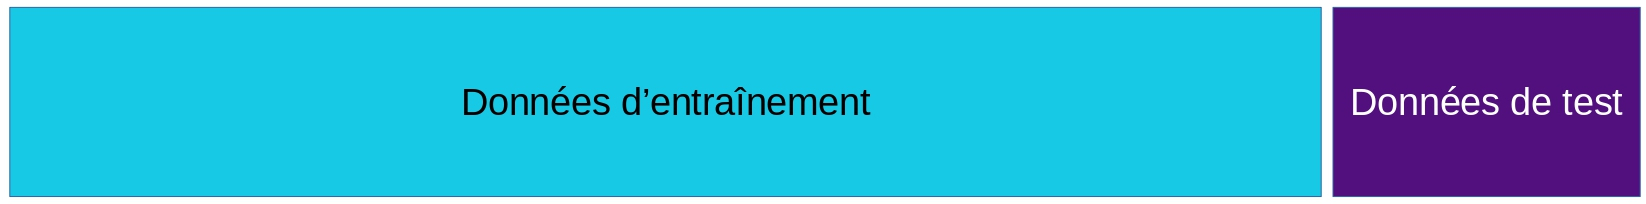

Maintenant, nous avons en plus un jeu de donn√©es de validation.

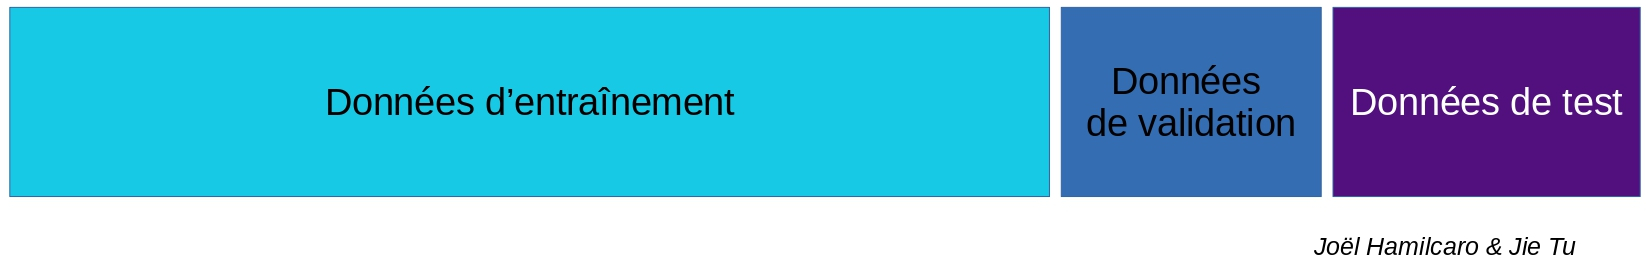

Comme pr√©c√©demment, on peut observer la distribution des donn√©es de validation et des donn√©es d'entra√Ænement.

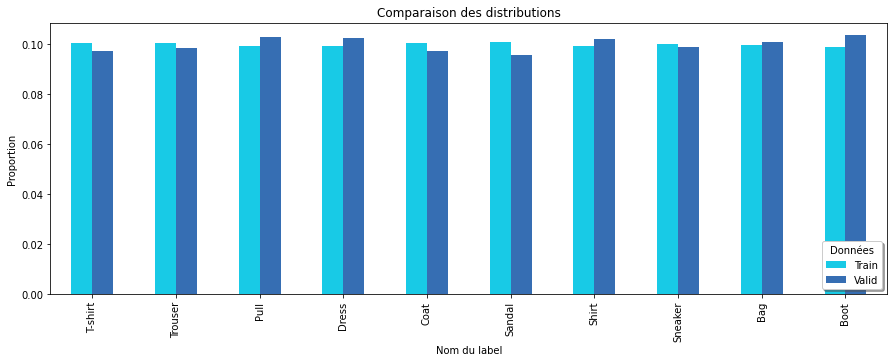

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images,
                                                      train_labels, 
                                                      test_size = 0.2, 
                                                      random_state=75)

df_train_split_prop = df_labels_distribution(X_train,y_train)
df_valid_split_prop = df_labels_distribution(X_valid,y_valid)

plt_distribution(df_train_split_prop,df_valid_split_prop,valid=True).show()

On peut voir que les donn√©es d'entra√Ænement et de validation sont de distribution "quasi"-uniforme. Toutes les classes sont quantitativement bien repr√©sent√©s.

On peut maintenant pr√©parer nos donn√©es pour l'entra√Ænement.

In [28]:
X_train, y_train = preprocess(X_train,y_train)
X_valid, y_valid = preprocess(X_valid,y_valid)

## Entra√Ænement


Nous avons maintenant tous les √©l√©ments pour entra√Æner ce premier mod√®le.

In [29]:
def create_train_save_load(X_train, y_train, X_valid, y_valid, 
                           name, func, **kwargs) :
    """
    Create train and save the model, or load the model if exists
    
    Parameters
    ----------
    name :
        name of the model
    func :
        function for create and fit the model
    kwargs :
        arguments for function
        
    Returns
    ----------
    model, epoch, accuracy, val_accuracy, loss, val_loss 
    
    """
    if model_exists(name) : 
        model, epoch, accuracy, val_accuracy, loss, val_loss \
            = my_load_model_full(name)
    else :
        model, epoch, accuracy, val_accuracy, loss, val_loss, history \
            = func(X_train, y_train, X_valid, y_valid, name=name,**kwargs)
        save_model(model,history,name)
    return model, epoch, accuracy, val_accuracy, loss, val_loss 

In [30]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train, y_train, X_valid, y_valid, 
                             name="cnn",func=create_and_fit_CNN,epochs=100)

On peut observer l'evolution de la pr√©cision et de la perte en fonction des epochs.

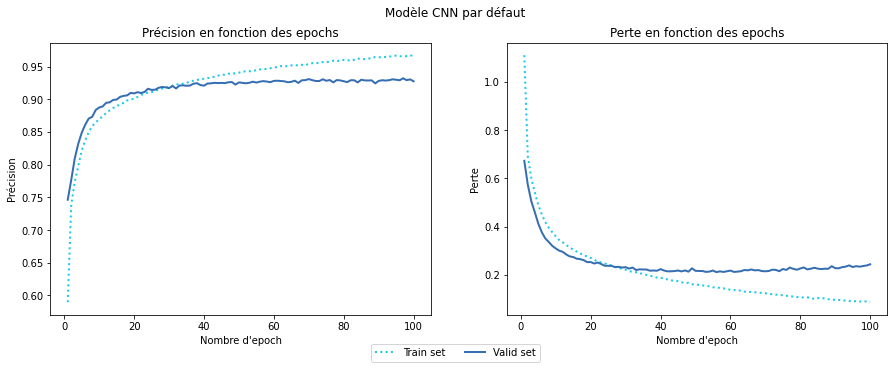

In [31]:
plot_acc_loss(epoch, accuracy, val_accuracy, loss, val_loss, 
              title='Mod√®le CNN par d√©faut', training=True)

Sur la courbe de pr√©cision pour le jeu de validation, on peut voir qu'on atteint un "plateau" au bout une vingtaine d'√©pochs (alors que la pr√©cision sur le jeu d'entra√Ænement continue d'augmenter). Ce plateau indique qu'il semble difficile de d√©passer un certain seuil de pr√©cision. Sur le graphique de droite, on constate un l√©ger overfitting. En effet, la courbe de perte augmente lentement √† partir d'une vingtaine d'it√©ration, alors que la perte sur le jeu d'entra√Ænement continue de diminuer.

## √âvaluation du mod√®le

###¬†Un exemple de pr√©diction

On peut d√©sormais √©valuer ce premier mod√®le sur notre jeu de test. On demande au mod√®le de pr√©dire une classe pour une image appartenant au jeu de test.

In [32]:
def show_prediction(y_pred, i, X_test) :
    """
    Show a prediction
    
    Parameters
    ----------
    y_pred :
        prediction
    i :
        index
    """
    print_title("Image :")
    img_to_plt(i,X_test).show()
    print_title("Probabilit√© par classe :")
    for key,val in label_dict.items() :
        print(f'{val} : %.4f' % y_pred[i][key] )
    print_title("Pr√©diction : ") 
    print(label_dict[np.argmax(y_pred[i])].upper())  
    return
    
def example_prediction(y_pred, X_test) :
    """
    Show an example of prediction
    
    Parameters
    ----------
    y_pred :
        prediction
    """
    seed(22)
    i = np.random.randint(0,len(X_test))
    show_prediction(y_pred, i, X_test)
    return


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



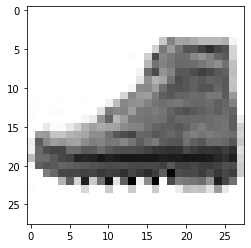


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilit√© par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0033
Bag : 0.0000
Boot : 0.9967

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pr√©diction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

BOOT


In [33]:
X_test, y_test = preprocess(test_images,test_labels)
y_pred = model.predict(X_test)
example_prediction(y_pred, X_test)

Cet exemple de pr√©diction est correct.

### Score sur le jeu de test

Maintenant, on va √©valuer notre mod√®le sur l'ensemble des donn√©es du jeu de test. Les m√©triques que nous allons utiliser pour l'√©valuation (g√©n√©rale) sont les suivantes : 
- la **pr√©cision** 
- la **perte**

De plus, pour chaque classe, on va regarder quelles sont les types de v√™tements difficiles √† distinguer. **On va le montrer visuellement √† travers des matrices de confusion**. Pour chaque classe, on va de plus √©valuer la **pr√©cision**, le **rappel**, et le **F-Score**.

In [34]:
def append_evaluation(df,model,X_test,y_test,y_pred) :
    """
    Appends results test in the dataframe 
    
    Parameters
    ----------
    df :
        dataframe
    model :
        model
    X_test :
        test images
    y_test :
        test labels
    y_pred :
        predicted labels
        
    Returns
    ----------
    dataframe
    
    """
    score = model.evaluate(X_test, y_test, verbose=0)
    new_row = {'Model': model.name, 'Accuracy': score[1], 'Loss' : score[0]}
    return df.append(new_row, ignore_index=True)

def show_evaluation(model, X_test, y_test, y_pred) :
    """
    Show confusion matrix
    
    Parameters
    ----------
    model :
        model
    X_test :
        test images
    y_test :
        test labels
    y_pred :
        predicted labels
        
    Returns
    ----------
    dataframe
    
    """
    score = model.evaluate(X_test, y_test, verbose=0)
    print_title('Perte sur le jeu de test :')
    print('%.4f' % score[0])
    print_title('Pr√©cision sur le jeu de test :')
    print('%.4f' % score[1])
    pred_classes = np.argmax(y_pred,axis = 1)
    true_classes = np.argmax(y_test,axis = 1)
    print_title('Matrice de confusion et m√©triques de classification :')
    cmat = confusion_matrix( pred_classes , true_classes, normalize=None ) 
    f,ax = plt.subplots(figsize=(15,5))
    sns.heatmap(cmat, annot=True, fmt= '.0f', 
                xticklabels=label_dict.values(), 
                yticklabels=label_dict.values(), cmap="Purples")
    plt.xlabel("Classes pr√©dites")
    plt.ylabel("Vraies classes")
    plt.title("Matrice de confusion")
    plt.show()
    target_names = [label_dict[i] for i in range(NB_CLASSES)]
    x = classification_report(true_classes, pred_classes, 
                              target_names=target_names, digits=4, 
                              output_dict=True, zero_division=0)
    df = pd.DataFrame(x)[ label_dict.values() ].head(3)
    display(df.style.background_gradient(axis=1, cmap='Purples'))
    return

In [35]:
df = pd.DataFrame()
df["Model"] = None
df["Accuracy"] = None
df["Loss"] = None
df = append_evaluation(df,model,X_test,y_test,y_pred)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.2683

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Pr√©cision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.9221

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~ Matrice de confusion et m√©triques de classification : ~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



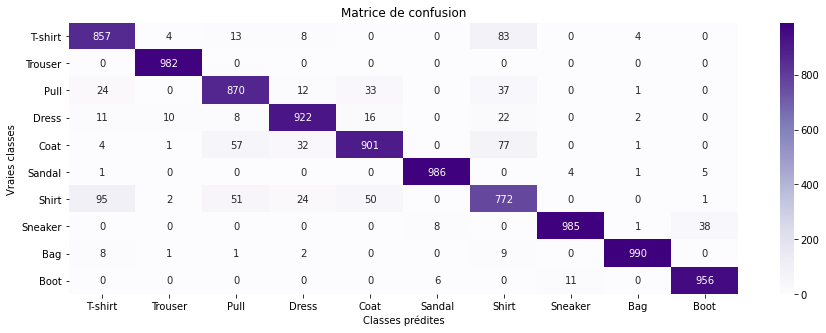

In [36]:
show_evaluation(model, X_test, y_test, y_pred)

<div class='alert alert-info' role='alert'><p>
    
Ce premier mod√®le a des scores tr√®s satisfaisants (pr√©cision de plus de **92%**)

</p></div>

*   Comme le montre la matrice de confusion il y a peu de confusions
*   Les quelques confusions que l'on peut observer sont les suivantes : 
    - Quelques confusions entre Shirt et T-shirt
    - Des confusions entre les hauts du corps de mani√®re g√©n√©rale : Shirt, T-shirt, Pull , Dress, Coat
    - Quelques confusions entre Boot et Sneakers
    
Cela peut s'expliquer logiquement par la forme similaire entre les diff√©rentes classes de haut du corps et les diff√©rentes classes de chaussures.

<div class='alert alert-info' role='alert'><p>

On peut observer que le mod√®le a le plus de difficult√©s pour les pr√©dictions concernant les chemises (Shirt).

</p></div>

On peut expliquer cela par le fait que pour identifier une chemise, on a besoin d'observer certains d√©tails de l'image (comme le col). Contrairement aux autres classes de v√™tement qui s'identifient facilement √† partir de leur forme.

## Ajustement manuel des hyperparam√®tres


Nous allons maintenant essayer d'am√©liorer notre mod√®le en ajustant les hyperparam√®tres manuellement. Cela nous permettra de discuter des diff√©rents effets qu'auront les hyperparam√®tres sur les performances du mod√®le.

D'abord, on va d√©finir quelques fonctions utiles pour nos ajustements d'hyperaparam√®tres.

In [37]:
def test_hyperparameters(param_values, param_name, name_func) :
    """
    
    Appends results test in the dataframe 
    
    Parameters
    ----------
    param_values :
        value of parameter to test
    param_name :
        name of parameter to test
    name_func :
        function to create name
        
    Returns
    ----------
    model_cnn_list,epoch_list,accuracy_list,val_accuracy_list,loss_list,val_loss_list
    
    """
    model_cnn_list = []
    epoch_list = []
    accuracy_list = []
    val_accuracy_list = []
    loss_list = []
    val_loss_list = []
    for param_value in param_values :
        name = name_func(param_value)
        if model_exists(name) :
            model_cnn, epoch, accuracy, val_accuracy, \
            loss, val_loss = my_load_model_full(name)
        else :
            model_cnn, epoch, accuracy, val_accuracy, \
                loss, val_loss, history_cnn \
                = create_and_fit_CNN(X_train, y_train, X_valid, y_valid,
                                     epochs=100, name=name,
                                     param_name=param_name,param_value=param_value)
            save_model(model_cnn,history_cnn,name)
        model_cnn_list.append(model_cnn)
        epoch_list.append(epoch)
        accuracy_list.append(accuracy)
        val_accuracy_list.append(val_accuracy)
        loss_list.append(loss)
        val_loss_list.append(val_loss)
    return model_cnn_list,epoch_list,accuracy_list,val_accuracy_list, \
            loss_list,val_loss_list


def plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,val_accuracy_list,loss_list,val_loss_list,param_values, training=False) :
    """
    
    Plot results of hyperparameters tests
    
    Parameters
    ----------
    model_cnn_list :
        list of model
    epoch_list :
        list of epochs
    accuracy_list :
        list of accuracy
    val_accuracy_list :
        list of validation accuracy
    loss_list :
        list of loss
    val_loss_list :
        list of validation loss
    param_values :
        list of parameters values
        
    """
    labels = list(map(lambda x : str(x),param_values))
    plot_acc_loss(epoch_list[0], accuracy_list, val_accuracy_list, loss_list, val_loss_list, title="Impact de l'hyperparam√®tre "+param_name, multiple=True, training=training, labels=labels)

### Taux d'apprentissage : `learning_rate`

Le premier param√®tre que nous allons modifier est le "pas" de notre optimiseur (nous avons choisi l'optimiseur "ADAM"). Dans le mod√®le pr√©c√©dent, nous avons gard√© la valeur par d√©faut du pas (0.0001).

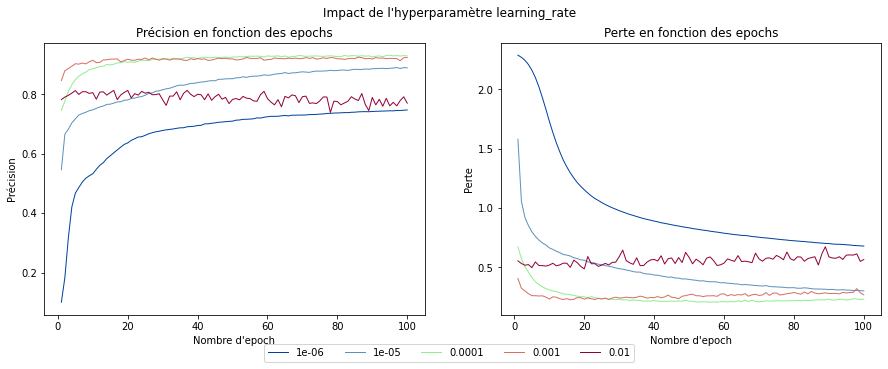

In [38]:
param_values = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
param_name = 'learning_rate'
name_func = lambda x : 'lr'+str(x)
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

On peut voir que la valeur par d√©faut (la valeur 0.0001 repr√©sent√©e en vert), est la meilleure. Une valeur de pas trop grande entraine des perturbations qui emp√™chent la progression. En revanche, un pas trop petit ne permet pas de progresser de mani√®re efficace. La valeur par d√©faut est un bon compromis.

### Taille du batch : `batch_size`

On s'int√©resse ici √† la taille des batchs. Pr√©c√©demment nous avons utilis√© une taille de batch de 64.

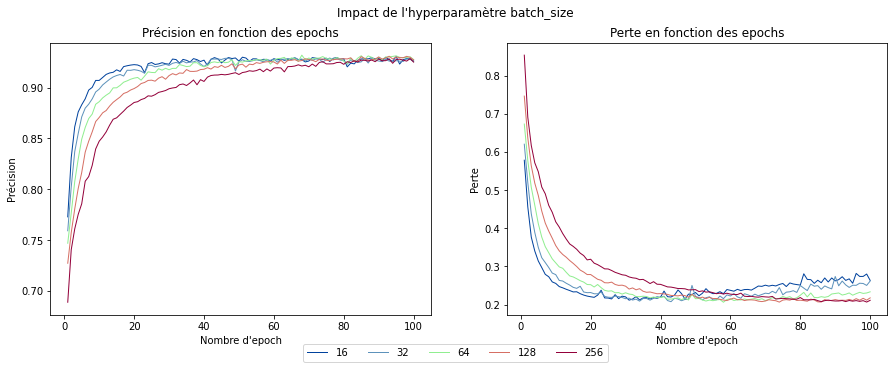

In [39]:
param_values = [16,32,64,128,256]
param_name = 'batch_size'
name_func = lambda x : 'batch'+str(x)
model_cnn_list,epoch_list,accuracy_list,\
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

On peut voir que si la taille du batch est trop petite, on a des perturbations et l'overfitting peut survenir tr√®s vite. En revanche si la taille du batch est trop grande, on met beaucoup de temps √† atteindre le "plateau". Les valeurs 64 et 128 sont des plut√¥t bonnes valeurs. 

### Taille des filtres des couches de covolution : `kernel_size`

On va maintenant modifier la taille des filtres des couches de convolution

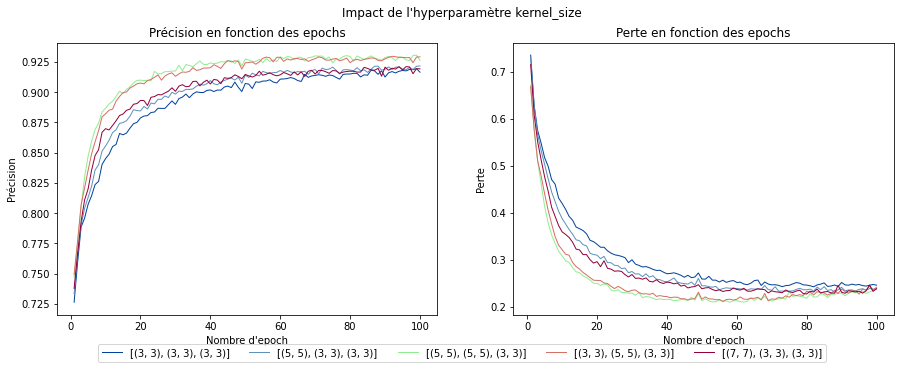

In [40]:
param_values = [[(3,3),(3,3),(3,3)],
                [(5,5),(3,3),(3,3)],
                [(5,5),(5,5),(3,3)],
                [(3,3),(5,5),(3,3)],
                [(7,7),(3,3),(3,3)]]
param_name = 'kernel_size'
name_func = lambda x : 'ks_'+str(x[0][0])+'_'+str(x[1][0])+'_'+str(x[2][0])
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

La taille des filtres sugg√©r√©e en √©nonc√© (5x5, 5x5 et 3x3) nous donne des meilleurs r√©sultats que les autres combinaisons que nous avons test√©es. 

### Nombre de noyaux : `filters` 

On va maintenant modifier le nombre de filtres des couches de convolution. On va tester les trois patterns suivants :  
- le nombre de filtre augmente avec la profondeur des couches
- le nombre de filtre reste le m√™me pour toutes les couche de convolution
- le nombre de filre diminue avec la profondeur des couches

**Nombres croissants de filtre**

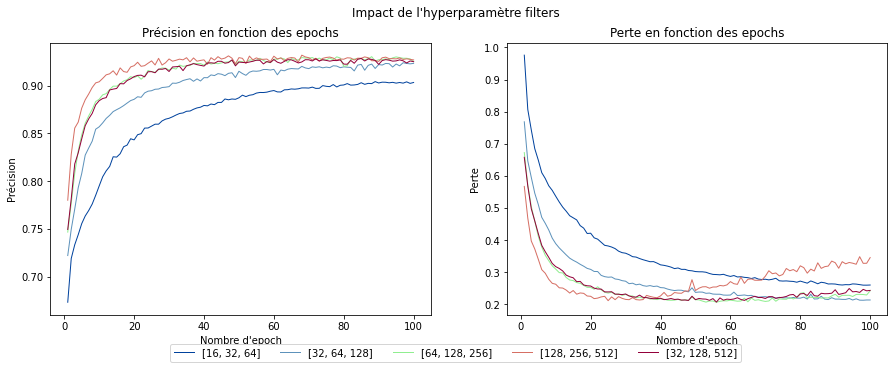

In [41]:
param_values = [[16,32,64] , [32,64,128] , 
                [64,128,256] , [128,256,512], [32, 128, 512] ]
param_name = 'filters'
name_func = lambda x : 'nbk_'+str(x[0])+'_'+str(x[1])+'_'+str(x[2])
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

**Nombres constants de filtres**

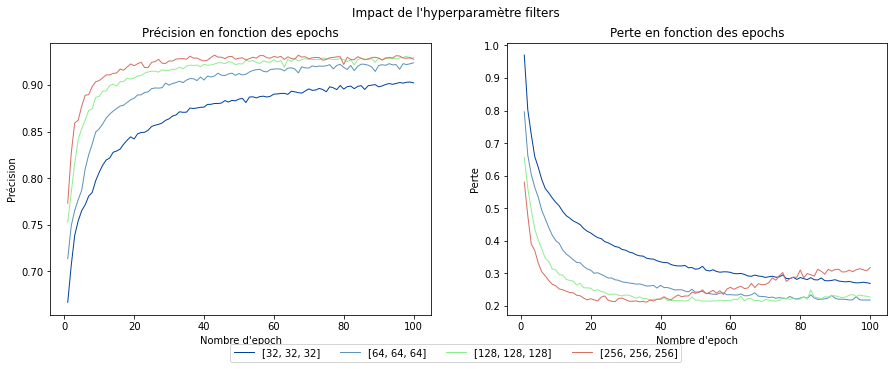

In [42]:
param_values =  [ [32,32,32] , [64,64,64] , [128,128,128] , [256,256,256] ]
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

**Nombres d√©croissants de filtres**

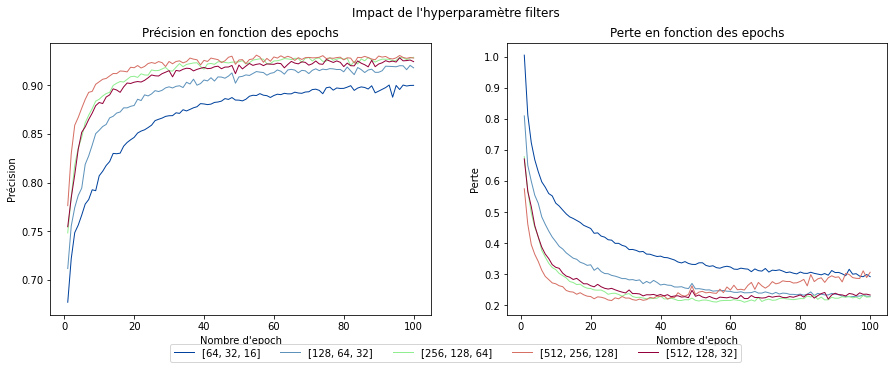

In [43]:
param_values =  [[64,32,16], 
                 [128,64,32], 
                 [256,128,64], 
                 [512,256,128],  
                 [512,128,32] ]
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

Dans les trois cas, on obtient des pr√©cision et des pertes assez similaires. On peut aussi observer que si le nombre de filtre est trop grand, on observe de l'overfitting. Enfin, si le nombre de filtre est trop petit, le mod√®le a plus de mal √† apprendre (la pr√©cision n'augmente pas assez et la perte diminue trop lentement). 

### Dimension en sortie de la couche dense : `units`

Cette fois, on regarde l'impact du nombre de neurones de la couche dense sur notre mod√®le.

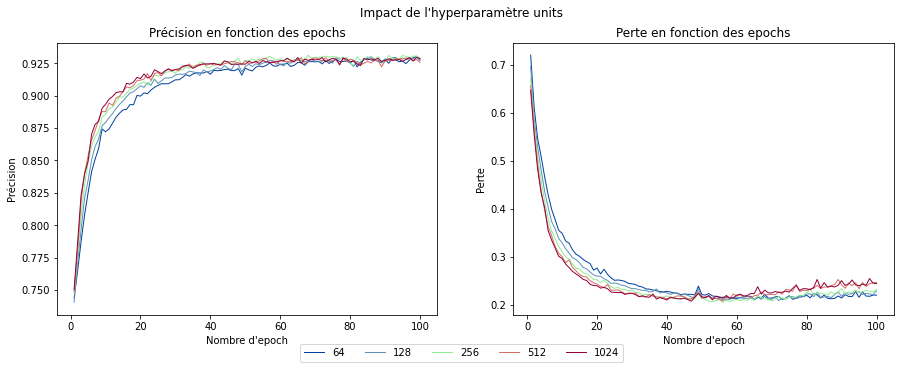

In [44]:
param_values = [64, 128, 256, 512, 1024]
param_name = 'units'
name_func = lambda x : 'units_'+str(x)
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list, loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

Encore une fois, si la valeur de cet hyperparam√®tre est trop grand, on observe de l'overfitting. Pour des valeurs tr√®s petites (ici 64), on met plus de temps √† atteindre le "plateau". De nouveau, la valeur sugg√©r√©e par l'√©nonc√© est un bon compromis.

### Taux de dropout : `Dropout.rate`

On cherche maintenant √† modifier les probabilit√©s de dropout.

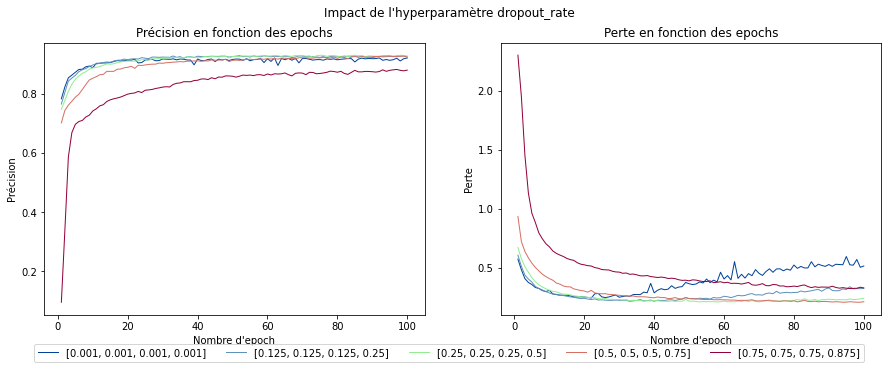

In [45]:
param_values = [
                [0.001, 0.001, 0.001, 0.001 ], 
                [0.125, 0.125, 0.125, 0.25 ], 
                [0.25, 0.25, 0.25, 0.5 ], 
                [0.5, 0.5, 0.5 , 0.75 ], 
                [0.75, 0.75, 0.75, 0.875 ] ]
param_name = 'dropout_rate'
name_func = lambda x : 'drop_'+str(x[0])+"_"+str(x[1])+"_"+str(x[2])+"_"+str(x[3])
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list, loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

√Ä probabilit√© tr√®s faible de dropout, on observe un flagrant overfitting. Cela s'explique, car si la probabilit√© de dropout est trop faible, on garde presque toutes les informations, ce qui conduit √† du sur-apprentissage. √Ä probabilit√© √©lev√©e, on perd en efficacit√© (moins de pr√©cision et plus de perte). La valeur sugg√©r√©e par l'√©nonc√© est encore une fois celle qui offre les meilleurs r√©sultats.

### Fen√™tre de Max-Pooling `MaxPooling2D.pool_size` 

Pour finir, on va modifier les dimensions des fen√™tres de Max Pooling.

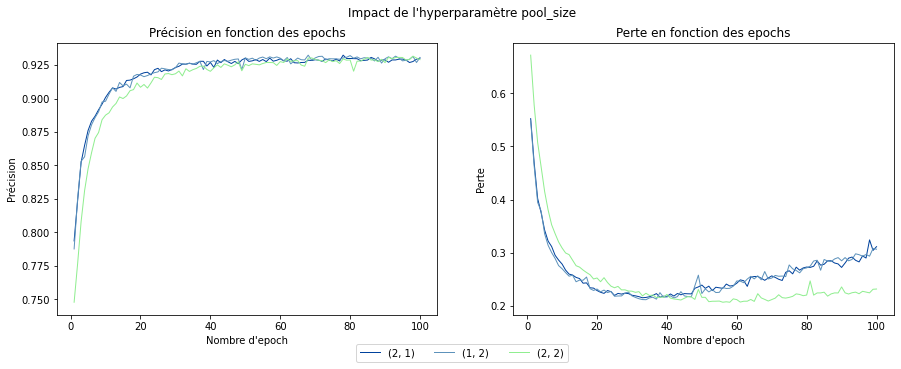

In [46]:
param_values = [ (2,1), (1,2), (2,2) ]
param_name = 'pool_size'
name_func = lambda x : 'pool_'+str(x[0])+'_'+str(x[1])
model_cnn_list,epoch_list,accuracy_list,\
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,val_accuracy_list,
                     loss_list,val_loss_list,param_values)

Un Max Pooling de taille 2x2 semble √™tre plus performant que ceux de taille 2x1 et 1x2.

## Early-Stopping 

On va maintenant mettre en place l'Early-Stopping pour √©viter les ph√©nom√®nes d'overfitting. L'early-stopping va arr√™ter l'entra√Ænement lorsque la perte sur le jeu de validation se met √† augmenter pendant plusieurs epochs d'affil√©es.

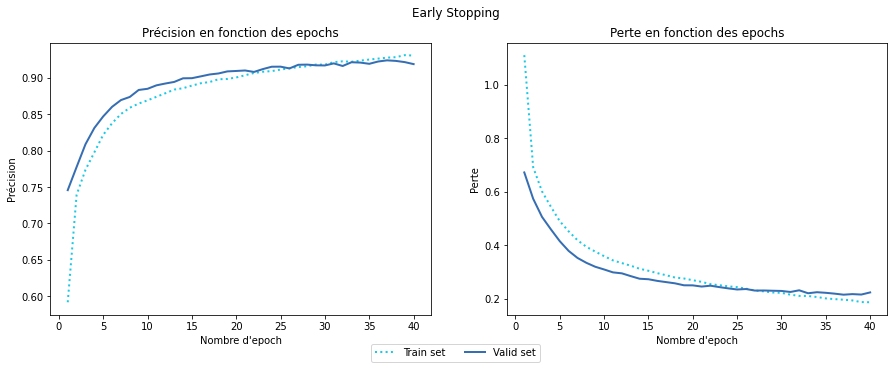

In [47]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train, y_train, X_valid, y_valid, 
                             name="early_stop_cnn",func=create_and_fit_CNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='Early Stopping', training=True)

<div class='alert alert-info' role='alert'><p>
    
On peut donc voir que l'entra√Ænement s'arr√™te √† environ 40 epochs.
    
</p></div>




+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.2398

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Pr√©cision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.9136

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~ Matrice de confusion et m√©triques de classification : ~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



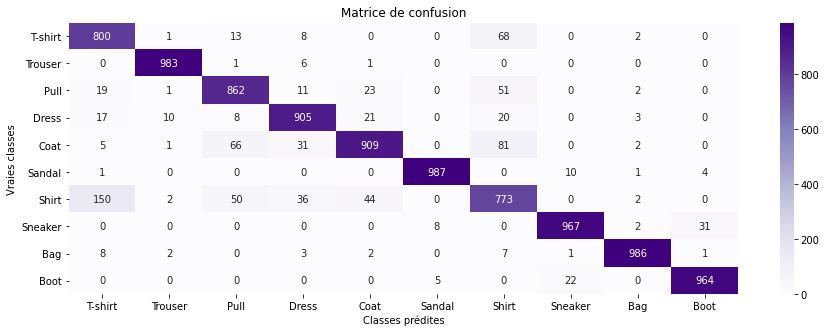

In [48]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model, X_test, y_test, y_pred)

In [49]:
def compare_models(df) :
    return df.style.background_gradient(axis=0, cmap='Purples', subset=['Accuracy'])\
            .background_gradient(axis=0, cmap='Purples_r', subset=['Loss'])

compare_models(df)

<div class='alert alert-info' role='alert'><p>
    
Ainsi, on a une perte moins grande que sur le mod√®le par d√©faut. Mais on perd l√©g√®rement en pr√©cision. Les pr√©dictions concernant les chemises (*Shirt*) sont toujours celles qui posent le plus de difficult√©s.
    
</p></div>




## Recherche automatique d'hyperparam√®tres

Nous avons vu dans les sections pr√©c√©dentes l'impact des hyperparam√®tres en modifiant leurs valeurs manuellement. Maintenant, nous allons faire une recherche automatique pour essayer de trouver la meilleure combinaison de valeurs des hyperparam√®tres. Nous effectuerons une recherche al√©atoire (avec `keras_tuner.RandomSearch`). Cette recherche n'est pas exhaustive, car elle ne teste pas toutes les combinaisons possibles. Cependant, elle permet d'obtenir rapidement des r√©sultats satisfaisants. 

Gr√¢ce aux ajustements manuels que nous avons faits pr√©c√©demment, on a une id√©e des hyperparam√®tres qu'il peut √™tre pertinent de tester. On va donc se restreindre aux tailles de filtres. En effet, les diff√©rentes valeurs donnaient des r√©sultats similaires. Il √©tait difficile de d√©duire quels √©taient les "meilleures" tailles de filtres. Les autres hyperparam√®tres (pas, taille du batch, taille des noyaux...) seront fix√©s aux valeurs optimales que nous avons obtenues. Cela permettra d'all√©ger l'algorithme de recherche automatique qui peut √™tre tr√®s couteuse.

In [50]:
def create_tuned_defaultCNN(hp) :
    """
    
    Search best hyperparameters combination for the default CNN architecture
    
    Parameters
    ----------
    hp :
        tuner
  
    Returns
    ----------
    model_cnn
    
    """
    # Fix randomness for reproductibility
    tf.random.set_seed(75) 
    seed(75)
    input_shape = INPUT_SHAPE
    model_cnn = Sequential(name="DefaultCNN_tuned")
    model_cnn.add(
        Conv2D(
            filters=hp.Choice('filters_1',values = [64,128,256]), 
            kernel_size=5, 
            activation='relu', 
            input_shape=input_shape, 
            name='Conv2D_1')
    )
    model_cnn.add(
        MaxPooling2D(
            pool_size=(2,2), 
            name='MaxPool_1')
    ) 
    model_cnn.add(
        Dropout(
            rate=0.25, 
            name='Dropout_1')
    )
    model_cnn.add(
        Conv2D(
            filters=hp.Choice('filters_2',values = [64,128,256]), 
            kernel_size=5, 
            activation='relu', 
            name='Conv2D_2'
        )
    )
    model_cnn.add(
        MaxPooling2D(
            pool_size=(2,2), 
            name='MaxPool_2')
    )
    model_cnn.add(
        Dropout(
            rate=0.25, 
            name='Dropout_2')
    )
    model_cnn.add(
        Conv2D(
            filters=hp.Choice('filters_3',values = [64,128,256]), 
            kernel_size=3, 
            activation='relu', 
            name='Conv2D_3')
    )
    model_cnn.add(
        MaxPooling2D(
            pool_size=(2,2), 
            name='MaxPool_3')
    )
    model_cnn.add(
        Dropout(
            rate=0.25, 
            name='Dropout_3')
    )
    model_cnn.add(
        Flatten(
            name='Flatten_1')
    ) 
    model_cnn.add(
        Dense(
            units=hp.Choice('units', values=[128,256]), 
            activation='relu', 
            name='Dense_1')
    )
    model_cnn.add(
        Dropout(
            rate=0.5, 
            name='Dropout_4')
    )
    model_cnn.add(
        Dense(NB_CLASSES, activation='softmax', name='OUTPUT')
    )
    model_cnn.compile(
        loss=losses.categorical_crossentropy,
        optimizer=optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    return model_cnn

In [51]:
if model_exists('cnn_tuned') :
    model_cnn, history_cnn = my_load_model("cnn_tuned")
else :
    tuner = kt.RandomSearch(
        create_tuned_defaultCNN,
        objective='val_accuracy',
        max_trials=10
    )
    tuner.search(X_train, y_train, epochs=100, 
                 validation_data=(X_valid, y_valid), 
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                             patience=3)] )
    model_cnn = tuner.get_best_models()[0]
    save_model(model_cnn,None,"cnn_tuned")
    
print_params(model_cnn)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Architecture d√©taill√©e ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Model: "DefaultCNN_tuned"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 8, 8, 64)          102464    
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 4, 4, 64)          0         
________

<div class='alert alert-info' role='alert'><p>
    
On veut voir que le meilleur mod√®le obtenu par la recherche al√©atoire utilise de tailles de filtres de **64**, **64** et **256**.    
    
</p></div>




+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.2286

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Pr√©cision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.9192

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~ Matrice de confusion et m√©triques de classification : ~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



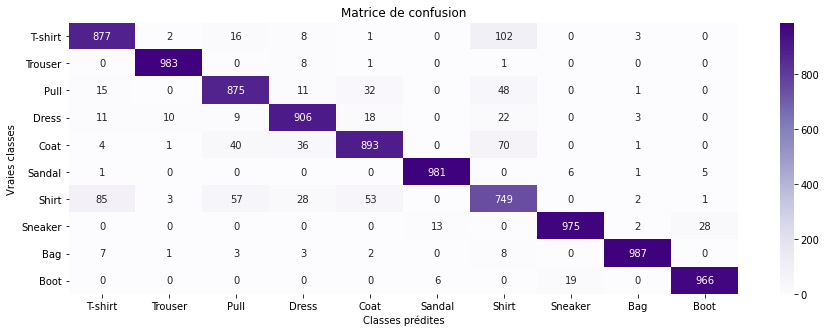

In [52]:
y_pred = model_cnn.predict(X_test)
df = append_evaluation(df,model_cnn,X_test,y_test,y_pred)
show_evaluation(model_cnn, X_test, y_test, y_pred)

In [53]:
compare_models(df)

<div class='alert alert-info' role='alert'><p>
    
On peut voir que les scores obtenus sont quasiment les m√™mes que sur le mod√®le par d√©faut. On perd tr√®s l√©g√®rement en pr√©cision, mais on a une meilleure perte. Ces diff√©rences sont vraiment minimes. Elles peuvent √™tre dues √† l'al√©a. De plus, les pr√©dictions concernant les chemises (*Shirt*) sont toujours celles qui posent le plus de difficult√©s.
    
</p></div>

## Augmentation des donn√©es

Dans cette section, on va effectuer une augmentation des donn√©es (ou *Data augmentation*). Cela consiste √† ajouter des nouvelles donn√©es d'entra√Ænement en effectuant des transformations sur les images originales (rotation, sym√©trie, modification du contraste ...). Entra√Æner le mod√®le sur les donn√©es augment√©es peut aider √† obtenir de meilleures performances.

On d√©finit ici les fonctions qui permettent d'effectuer la *Data augmentation*.

In [54]:
def transform_image(image) :
    """
    
    Transform an image with random flip and random noise
    
    Parameters
    ----------
    image :
        an image 
  
    Returns
    ----------
    image
    
    """
    flips = { 
        0 : lambda x : x    ,
        1 : tf.image.flip_left_right ,
    }
    decalages = {   
        0 : lambda x : resize_with_crop_or_pad( pad_to_bounding_box(x, 0, 4, 28, 32), 
                                               28,28 ) , 
        1 : lambda x : resize_with_crop_or_pad( pad_to_bounding_box(x, 4, 0, 32, 28), 
                                               28,28 ) , 
        2 : lambda x : resize_with_crop_or_pad( pad_to_bounding_box(x, 4, 4, 32, 32), 
                                               28,28 )
    } 
    gammas = {
        0 : lambda x : x,
        1 : lambda x : adjust_gamma(x, 0.5) ,
        2 : lambda x : adjust_gamma(x, 2) ,
    }
    flip_rand =  np.random.randint(0,len(flips)) 
    decal_rand =  np.random.randint(0,len(decalages)) 
    gamma_rand = np.random.randint(0,len(gammas)) 
    image = decalages[decal_rand](image)
    image = flips[flip_rand](image)
    image = gammas[gamma_rand](image)
    return image
  
def reset_shape(news) :
    """
    
    Resets images to their original shape
    
    Parameters
    ----------
    news :
        an array of new images (transformed)
  
    Returns
    ----------
    an array of images (same format as train_images)
    
    """
    news = np.reshape(np.array(news),(len(news),len(news[0]), len(news[0][0])))
    return news

def augmentation(train_images,train_labels):
    """
    
    Does the data augmentation
    
    Parameters
    ----------
    news :
        an array of new images (transformed)
  
    Returns
    ----------
    an array of images (same format as train_images)
    
    """
    # Fix randomness for reproducibility
    seed(7)
    new_train_images = train_images.copy()
    new_train_labels = train_labels.copy()
    new_train_images = reshape(train_images)
    new_train_images = list( 
        map( transform_image ,  new_train_images )
    )
    new_train_images=reset_shape(new_train_images)
    new_train_images = np.concatenate( (train_images,new_train_images) , axis=0)
    new_train_labels = np.concatenate( (train_labels,new_train_labels) , axis=0)
    return (new_train_images,new_train_labels)

On illustre ici un exemple d'image obtenue apr√®s *Data augmentation* :


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Exemple d'image originale ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



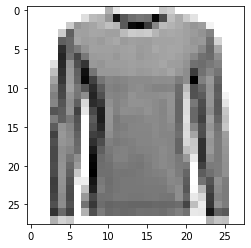


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~ Exemple d'image obtenue apr√®s augmentation ~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



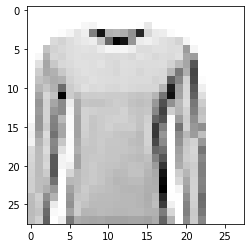

In [55]:
seed(87)
i = np.random.randint(0,len(train_images))
print_title("Exemple d'image originale")
train_images_tmp = reshape(train_images)
img_to_plt(i, images=train_images_tmp).show()
img1 = train_images_tmp[i]
img2 = transform_image( img1 )
train_images_tmp =  [ img2 ] 
train_images_tmp = reset_shape( train_images_tmp )
print_title("Exemple d'image obtenue apr√®s augmentation")
img_to_plt(0,train_images_tmp).show()

On cr√©√© ci-dessous notre ensemble de donn√©es d'entra√Ænement obtenues apr√®s *Data augmentation*.

In [56]:
%%time


(train_images_augmented, train_labels_augmented) \
    = augmentation(train_images, train_labels)

CPU times: user 2min 14s, sys: 852 ms, total: 2min 15s
Wall time: 2min 15s



+---------------------------------------------------------------------------+
¬¶~~~~~~~ √âchantillon des donn√©es d'entrainement (apr√®s augmentation) ~~~~~~~¬¶
+---------------------------------------------------------------------------+



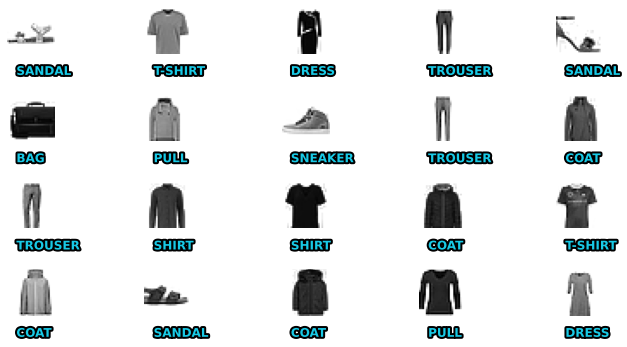

In [57]:
print_title("√âchantillon des donn√©es d'entrainement (apr√®s augmentation)")
plt_sample(4,5,images=train_images_augmented, labels=train_labels_augmented, 
           random_state=75, cmap="gray_r", head_0_tail_1=1).show()

### Entrainement du mod√®le sur les donn√©es augment√©es

On entra√Æne maintenant notre mod√®le sur les donn√©es augment√©es.

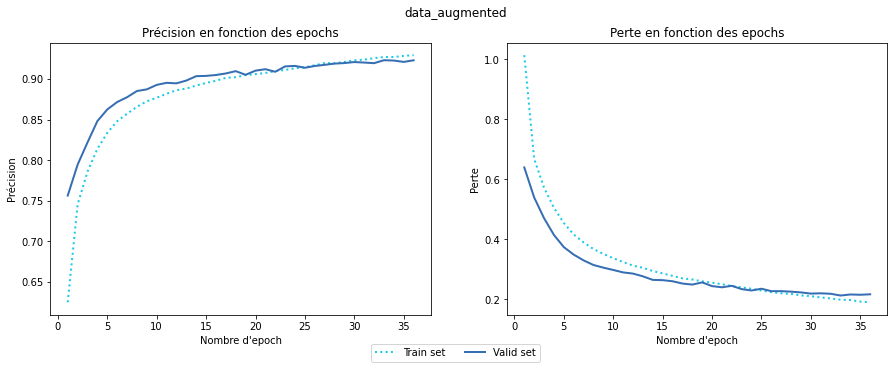

In [58]:
X_train_augmented, X_valid_augmented, y_train_augmented, y_valid_augmented \
    = train_test_split(train_images_augmented,train_labels_augmented, 
                       test_size = 0.2, random_state=75)
X_train_augmented, y_train_augmented = preprocess(X_train_augmented,y_train_augmented)
X_valid_augmented, y_valid_augmented = preprocess(X_valid_augmented,y_valid_augmented)

model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train_augmented, y_train_augmented,
                             X_valid_augmented, y_valid_augmented,
                             name="data_augmented",
                             func=create_and_fit_CNN, early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='data_augmented', training=True)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.2182

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Pr√©cision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.9210

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~ Matrice de confusion et m√©triques de classification : ~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



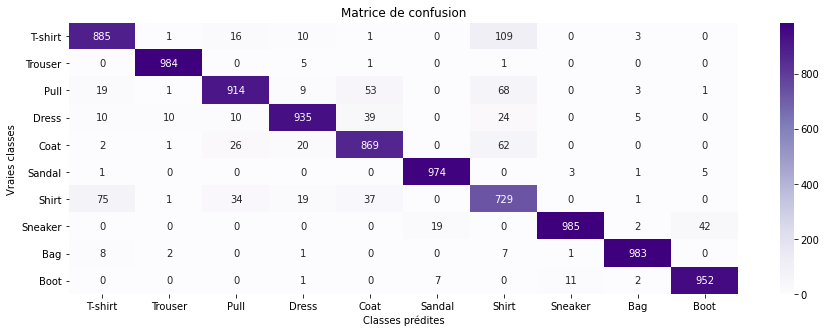

In [59]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model, X_test, y_test, y_pred)

In [60]:
compare_models(df)

<div class='alert alert-info' role='alert'><p>
    
On obtient ici une meilleure perte que sur le mod√®le par d√©faut. On perd l√©g√®rement en pr√©cision. Ces diff√©rences sont de nouveau tr√®s minimes.  De plus, les pr√©dictions concernant les chemises (*Shirt*) sont toujours celles qui posent le plus de difficult√©s.
    
</p></div>

## R√©sum√©

On affiche ici un r√©sum√© des diff√©rentes performances obtenues en fonction des diff√©rents mod√®les.

In [61]:
compare_models(df)

# Autres architectures 

Dans les sections pr√©c√©dentes, les changements obtenus en modifiant le mod√®le n'√©tait pas significatifs.

Ici, on va cr√©er des r√©seau neuronaux avec des architectures diff√©rentes, on observe si on obtient des am√©liorations significatives. 

## R√©seau de neurones √† propagation avant

Le premi√®re architecture que nous allons cr√©er est celle d'un r√©seaux de neurones √† propagation avant (*FFNN*) √† trois couches de plus en plus larges.

> - Couche de **dense** √† $64$ neurones 
> - Couche de **dense** √† $128$ neurones 
> - Couche de **dense** √† $256$ neurones 
> - Couche de perte avec activation **softmax**

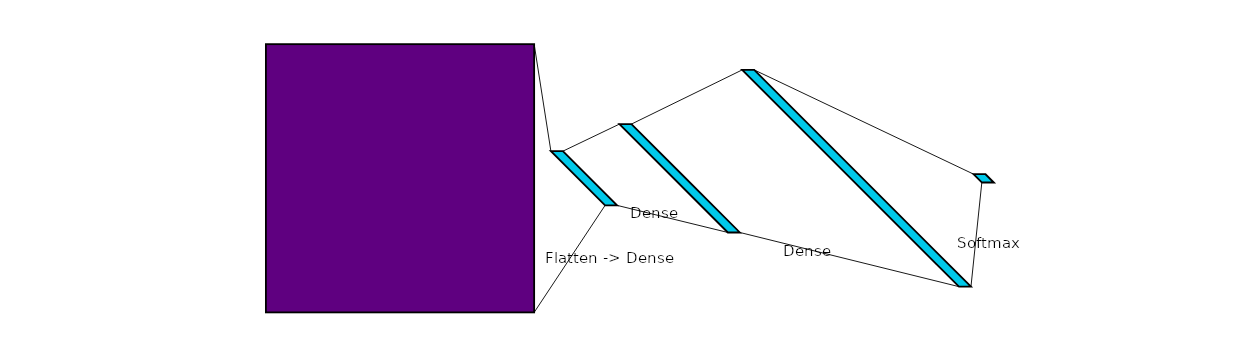

In [62]:
def create_FFNN(name="") :
    """
    
    Create a FFNN model
    
    Parameters
    ----------
    name :
        name of the model
  
    Returns
    ----------
    model_ffnn
    
    """
    # Fix randomness for reproducibility
    tf.random.set_seed(75) 
    seed(75)
    input_shape = INPUT_SHAPE 
    model_ffnn = Sequential(name="FFNN_"+name)
    model_ffnn.add(Flatten(input_shape=input_shape, name='Flatten_1'))
    model_ffnn.add(Dense(64, activation='relu', name='Densely_1'))    
    model_ffnn.add(Dense(128, activation='relu', name='Densely_2'))
    model_ffnn.add(Dense(256, activation='relu', name='Densely_3'))
    model_ffnn.add(Dense(NB_CLASSES, activation='softmax', name='Softmax'))
    model_ffnn.compile(
        loss=losses.categorical_crossentropy,
        optimizer=optimizers.Adam(),
        metrics=['accuracy']
    )
    return model_ffnn

def create_and_fit_FFNN(X_train,y_train,X_valid, y_valid,
                        epochs=100,name="", early_stop=True) :
    """
    Create a FFNN model and fit the model
    
    Parameters
    ----------
    X_train, y_train, X_valid, y_valid :
        train and valid datas
    epochs : 
        number of epochs
    name :
        name of the model
    early_stop :
        if True, do early stopping
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss
    
    """
    print_title("Entrainement du r√©seau neuronal "+name)
    model_ffnn = create_FFNN(name=name)
    return fit_NN(model_ffnn, X_train, y_train, X_valid, y_valid, 
                  epochs=epochs,verbose=1, early_stop=early_stop)

print_params(create_FFNN())


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Architecture d√©taill√©e ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Model: "FFNN_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
Densely_1 (Dense)            (None, 64)                50240     
_________________________________________________________________
Densely_2 (Dense)            (None, 128)               8320      
_________________________________________________________________
Densely_3 (Dense)            (None, 256)               33024     
_________________________________________________________________
Softmax (Dense)              (None, 10)                2570      
Total params: 94,15

### Entra√Ænement sur les donn√©es initiales

On va entra√Æner de mod√®le sur les donn√©es de base (sans *Data augmentation*) puis on affiche les scores obtenus.

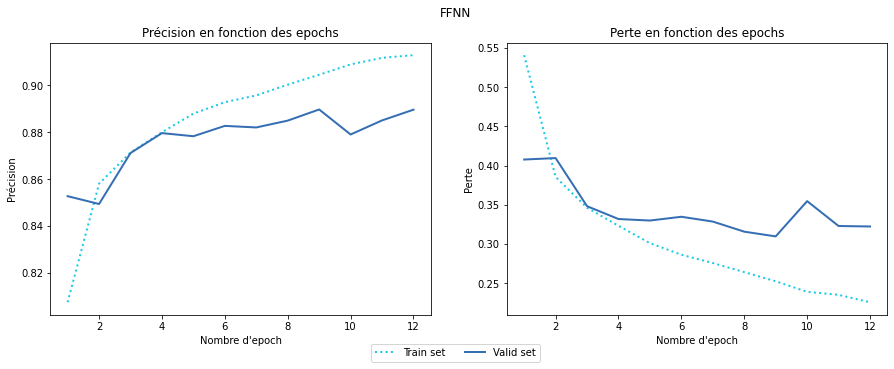

In [63]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train, y_train, X_valid, y_valid, 
                             name="ffnn",func=create_and_fit_FFNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='FFNN', training=True)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.3479

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Pr√©cision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.8772

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~ Matrice de confusion et m√©triques de classification : ~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



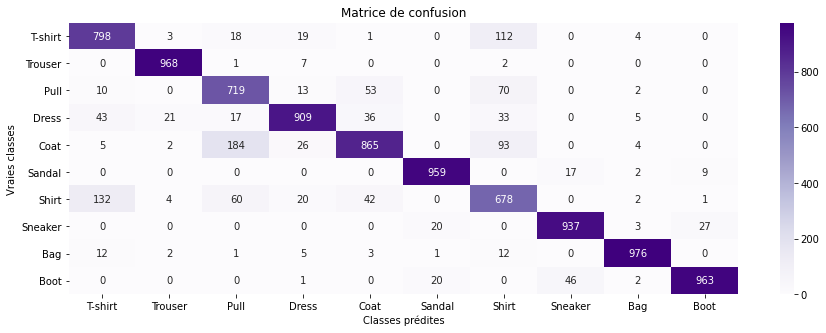

In [64]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [65]:
compare_models(df)

### Entra√Ænement sur les donn√©es augment√©es

On fait de m√™me avec les donn√©es augment√©es.

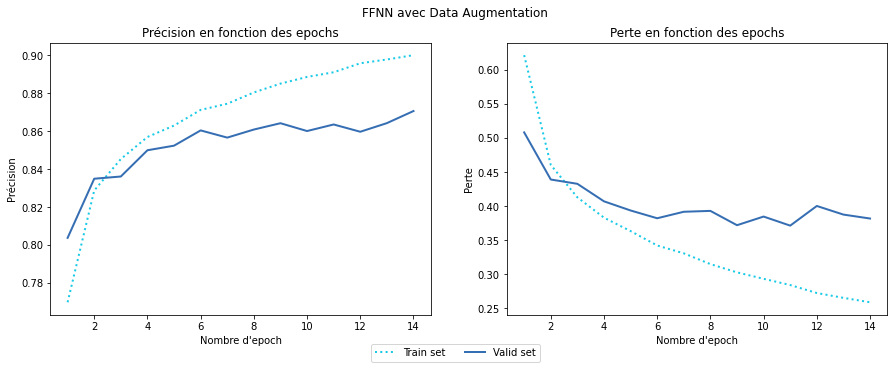

In [66]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train_augmented, y_train_augmented, 
                             X_valid_augmented, y_valid_augmented, 
                             name="ffnn_data_augmented",func=create_and_fit_FFNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='FFNN avec Data Augmentation', training=True)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.3542

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Pr√©cision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.8788

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~ Matrice de confusion et m√©triques de classification : ~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



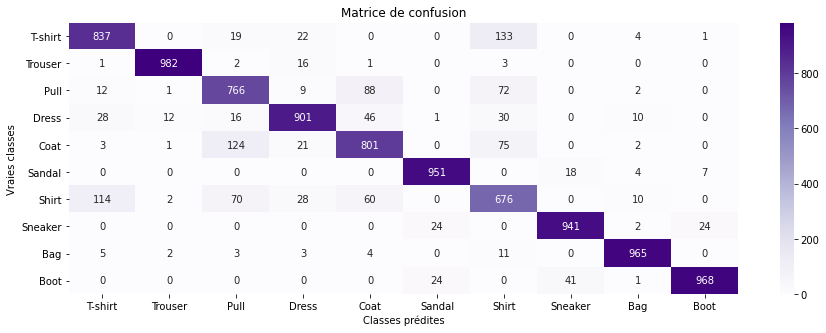

In [67]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [68]:
compare_models(df)

<div class='alert alert-info' role='alert'><p>
    
Ce mod√®le est clairement moins performant que le mod√®le CNN par d√©faut. Malgr√© tout, il obtient de plut√¥t bons scores (environ *87%* de pr√©cision). Avec cette architecture, les pr√©dictions concernant les chemises (*Shirt*) sont √©galement celles qui posent le plus de difficult√©s.
    
</p></div>

## CNN avec AveragePooling

Le deuxi√®me architecture que nous allons cr√©er est celle d'un r√©seau de neurone convolutif inspir√© du mod√®le par d√©faut. Cette fois-ci, on ne va pas utiliser des couches de Max Pooling. √Ä la place, nous allons utiliser des couches d'Average Pooling.

> - Couche de **convolution** √† $64$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **Average Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilit√© $0.25$
>
> - Couche de **convolution** √† $128$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **Average Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilit√© $0.25$
>
> - Couche de **convolution** √† $256$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **Average Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilit√© $0.25$
>
> - Couche **dense** √† $256$ neurones
> - Couche de **Dropout** avec probabilit√© $0.5$
> - Couche de perte avec activation **softmax**


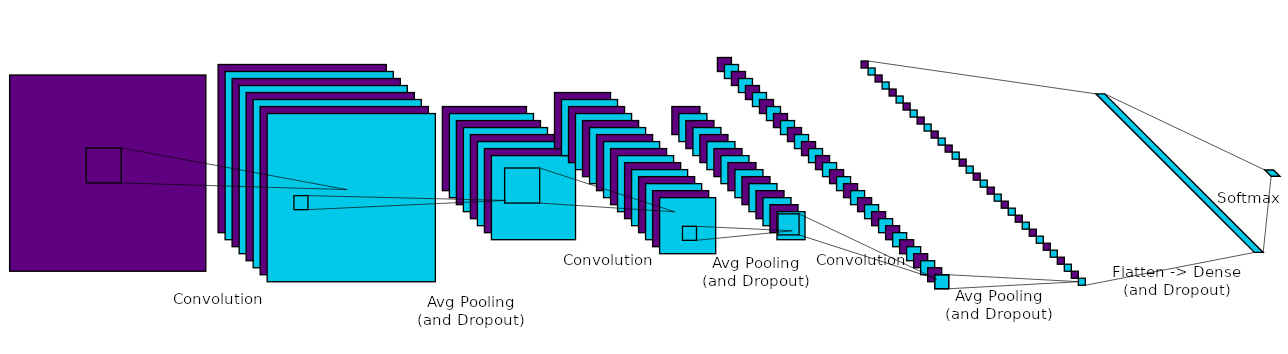

In [69]:
def create_avg_pool_CNN(name="") :
    """
    
    Create a CNN model with average pooling
    
    Parameters
    ----------
    name :
        name of the model
  
    Returns
    ----------
    model_cnn
    
    """
    # Fix randomness for reproducibility
    tf.random.set_seed(75) 
    seed(75)
    input_shape = INPUT_SHAPE
    model_cnn = Sequential(name="AvgPoolCNN_"+name)
    model_cnn.add(Conv2D(64, kernel_size=(5,5), activation='relu', 
                         input_shape=input_shape, name='Convolu_1'))
    model_cnn.add(AveragePooling2D(pool_size=(2,2), name='AvgPool_1'))
    model_cnn.add(Dropout(.25, name='Dropout_1'))
    model_cnn.add(Conv2D(128, kernel_size=(5,5), activation='relu', name='Convolu_2'))
    model_cnn.add(AveragePooling2D(pool_size=(2,2), name='AvgPool_2'))
    model_cnn.add(Dropout(.25, name='Dropout_2'))
    model_cnn.add(Conv2D(256, kernel_size=(3,3), activation='relu', name='Convolu_3'))
    model_cnn.add(AveragePooling2D(pool_size=(2,2), name='AvgPool_3'))
    model_cnn.add(Dropout(.25, name='Dropout_3'))
    model_cnn.add(Flatten(name='Flatten_1')) # On doit donner un vecteur 1D √† la couche dense
    model_cnn.add(Dense(256, activation='relu', name='Densely_1'))
    model_cnn.add(Dropout(.5, name='Dropout_4'))
    model_cnn.add(Dense(NB_CLASSES, activation='softmax', name='Softmax'))  
    model_cnn.compile(loss=losses.categorical_crossentropy,
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
    return model_cnn


def create_and_fit_avg_pool_CNN(X_train,y_train,X_valid, y_valid,
                                epochs=100,
                                name="",
                                early_stop=True) :
    """
    Create a CNN model with average pooling and fit the model
    
    Parameters
    ----------
    X_train, y_train, X_valid, y_valid :
        train and valid datas
    epochs : 
        number of epochs
    name :
        name of the model
    early_stop :
        if True, do early stopping
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss
    
    """
    print_title("Entrainement du r√©seau neuronal "+name)
    model_cnn = create_avg_pool_CNN(name=name)
    return fit_NN(model_cnn, X_train, y_train,X_valid, y_valid,
                  epochs=epochs,verbose=1, early_stop=early_stop)

print_params(create_avg_pool_CNN())


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Architecture d√©taill√©e ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Model: "AvgPoolCNN_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolu_1 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
AvgPool_1 (AveragePooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
Convolu_2 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
AvgPool_2 (AveragePooling2D) (None, 4, 4, 128)         0         
_____________

### Entra√Ænement sur les donn√©es initiales

On va entra√Æner de mod√®le sur les donn√©es de base (sans *Data augmentation*) puis on affiche les scores obtenus.

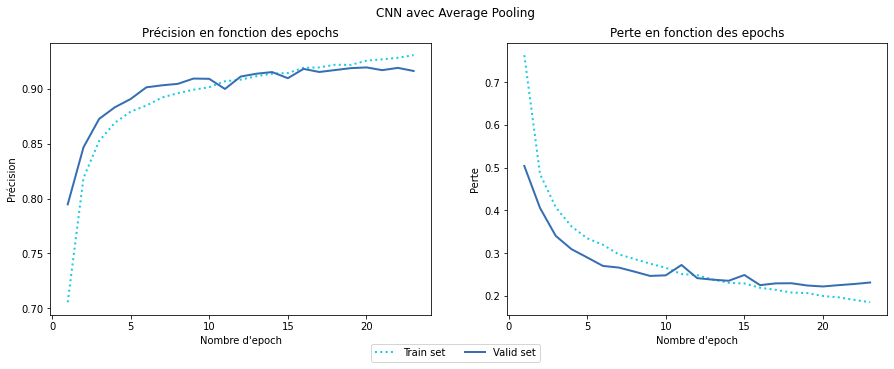

In [70]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train, y_train, X_valid, y_valid, 
                             name="cnn_avg_pool",func=create_and_fit_avg_pool_CNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='CNN avec Average Pooling', training=True)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.2497

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Pr√©cision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.9117

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~ Matrice de confusion et m√©triques de classification : ~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



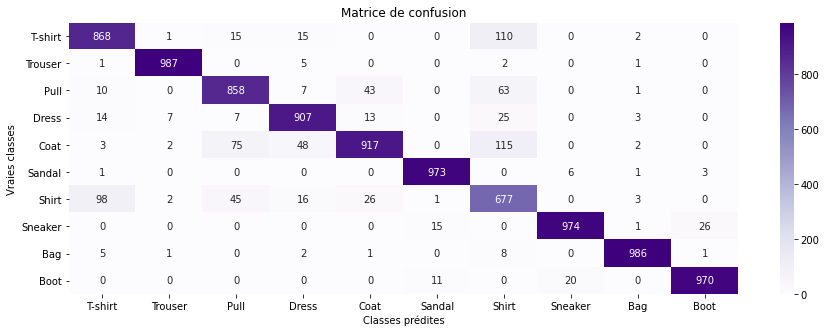

In [71]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [72]:
compare_models(df)

### Entra√Ænement sur les donn√©es augment√©es

On fait de m√™me avec les donn√©es augment√©es.

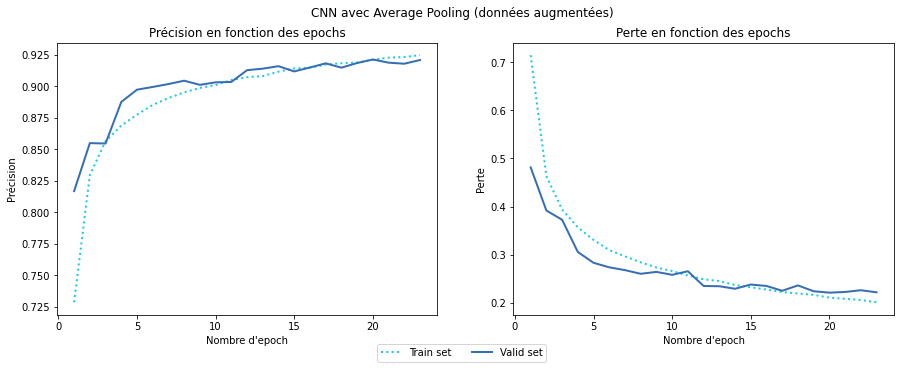

In [73]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train_augmented, y_train_augmented, 
                             X_valid_augmented, y_valid_augmented, 
                             name="cnn_avg_pool_data_augmented",func=create_and_fit_avg_pool_CNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='CNN avec Average Pooling (donn√©es augment√©es)', training=True)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.2282

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Pr√©cision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.9226

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~ Matrice de confusion et m√©triques de classification : ~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



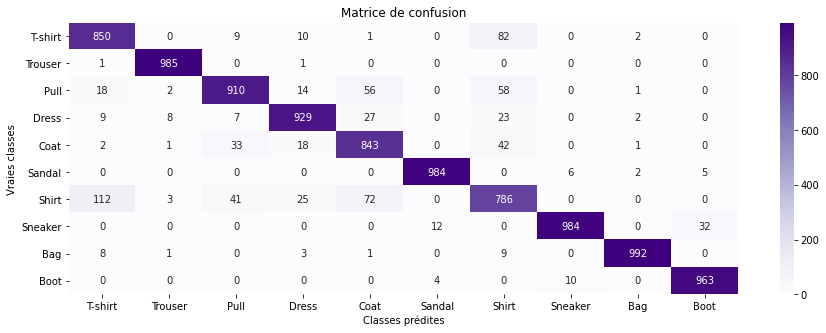

In [74]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [75]:
compare_models(df)

<div class='alert alert-info' role='alert'><p>
    
Ce mod√®le est aussi performant que le mod√®le CNN par d√©faut. On note qu'avec les donn√©es augment√©es on obtient une meilleure pr√©cision et une meilleure perte que sur le mod√®le CNN par d√©faut. Mais ces diff√©rences restent tr√®s minimes. De m√™me, avec cette architecture, les pr√©dictions concernant les chemises (*Shirt*) sont √©galement celles qui posent le plus de difficult√©s.
    
</p></div>

## CNN plus profond

La derni√®re architecture que nous allons cr√©er est celle d'une r√©seau neuronal convolutif plus profond que le mod√®le par d√©faut. On va ajouter de nombreuses couches de convolutions. L'architecture est la suivante :


> - Couche de **convolution** √† $64$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **convolution** √† $64$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **convolution** √† $128$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **convolution** √† $64$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **Max Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilit√© $0.25$
>
> - Couche de **convolution** √† $256$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **convolution** √† $64$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **Max Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilit√© $0.25$
>
> - Couche **dense** √† $512$ neurones
> - Couche de **Dropout** avec probabilit√© $0.5$
> - Couche de perte avec activation **softmax**

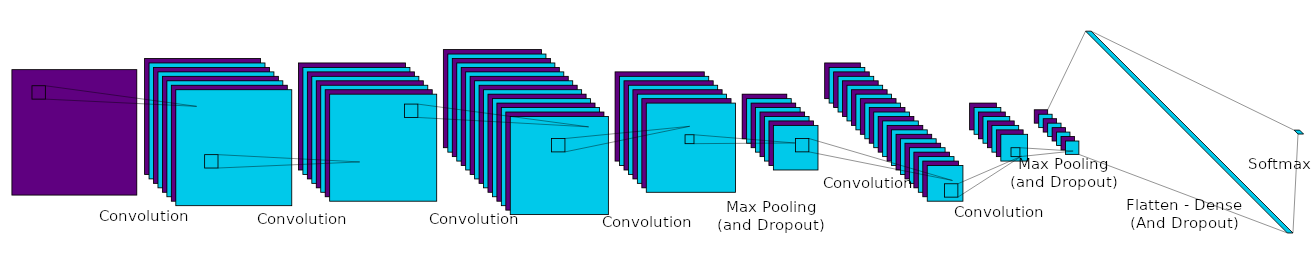

In [76]:
def create_DeeperCNN(name="") :
    """
    
    Create a Deeper CNN model 
    
    Parameters
    ----------
    name :
        name of the model
  
    Returns
    ----------
    model_cnn
    
    """
    # Fixer l'al√©atoire pour la reproductibilit√©
    tf.random.set_seed(75) 
    seed(75)
    input_shape = INPUT_SHAPE
    model_cnn = Sequential(name="DeeperCNN_"+name)
    model_cnn.add(Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         activation='relu', 
                         input_shape=input_shape, 
                         name='Convolu_1'))
    model_cnn.add(Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         activation='relu', 
                         input_shape=input_shape, 
                         name='Convolu_1bis'))
    model_cnn.add(Conv2D(filters=128, 
                         kernel_size=(3, 3), 
                         activation='relu',
                         name='Convolu_2'))
    model_cnn.add(Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         activation='relu', 
                         input_shape=input_shape, 
                         name='Convolu_2bis'))
    model_cnn.add(MaxPooling2D(pool_size=(2,2), 
                               name='MaxPool_2'))
    model_cnn.add(Dropout(rate=0.25, 
                          name='Dropout_2'))
    model_cnn.add(Conv2D(filters=256, 
                         kernel_size=(3, 3), 
                         activation='relu',
                         name='Convolu_3'))
    model_cnn.add(Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         activation='relu', 
                         input_shape=input_shape, 
                         name='Convolu_3bis'))
    model_cnn.add(MaxPooling2D(pool_size=(2,2), 
                               name='MaxPool_3'))
    model_cnn.add(Dropout(rate=0.25, 
                          name='Dropout_3'))
    model_cnn.add(Flatten(name='Flatten_4'))
    model_cnn.add(Dense(units=512, activation='relu', name='Densely_4'))
    model_cnn.add(Dropout(rate=0.5, 
                          name='Dropout_4'))
    model_cnn.add(Dense(units=10, activation = 'softmax'))  
    model_cnn.compile(loss=losses.categorical_crossentropy,
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
    return model_cnn


def create_and_fit_DeeperCNN(X_train,y_train,X_valid, y_valid,
                             epochs=100,name="", early_stop=True) :
    """
    Create a deeper CNN model and fit the model
    
    Parameters
    ----------
    X_train, y_train, X_valid, y_valid :
        train and valid datas
    epochs : 
        number of epochs
    name :
        name of the model
    early_stop :
        if True, do early stopping
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss

    """
    print_title("Entrainement du r√©seau neuronal "+name)
    model_cnn = create_DeeperCNN(name=name)
    return fit_NN(model_cnn,X_train, y_train,X_valid, y_valid,
                epochs=epochs,verbose=1, early_stop=early_stop)

print_params(create_DeeperCNN())


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Architecture d√©taill√©e ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

Model: "DeeperCNN_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolu_1 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
Convolu_1bis (Conv2D)        (None, 24, 24, 64)        36928     
_________________________________________________________________
Convolu_2 (Conv2D)           (None, 22, 22, 128)       73856     
_________________________________________________________________
Convolu_2bis (Conv2D)        (None, 20, 20, 64)        73792     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 10, 10, 64)        0         
______________

### Entra√Ænement sur les donn√©es initiales

On va entra√Æner de mod√®le sur les donn√©es de base (sans *Data augmentation*) puis on affiche les scores obtenus.

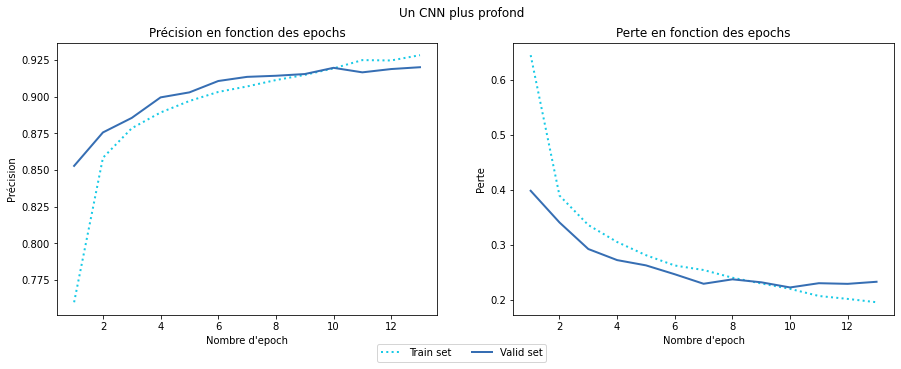

In [77]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train, y_train, 
                             X_valid, y_valid, 
                             name="deeper_cnn",func=create_and_fit_DeeperCNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='Un CNN plus profond', training=True)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.2440

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Pr√©cision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.9150

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~ Matrice de confusion et m√©triques de classification : ~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



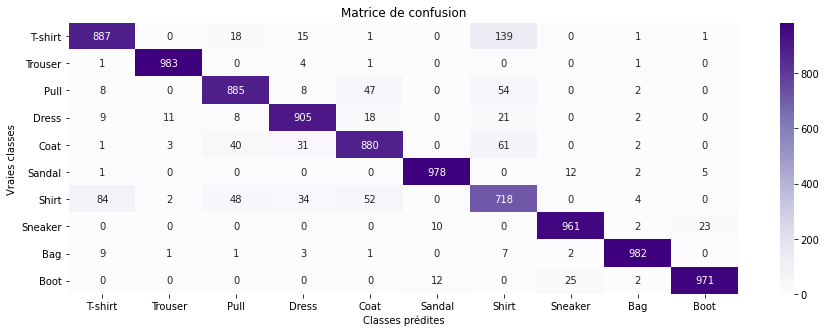

In [78]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [79]:
compare_models(df)

### Entra√Ænement sur les donn√©es augment√©es

On fait de m√™me avec les donn√©es augment√©es.

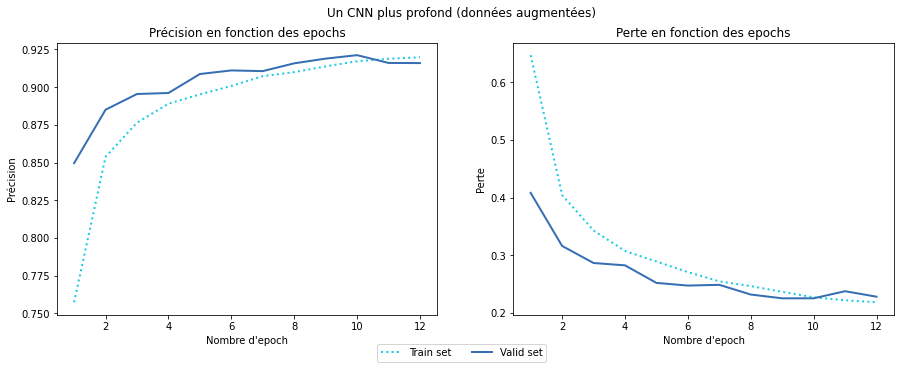

In [80]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train_augmented, y_train_augmented, 
                             X_valid_augmented, y_valid_augmented, 
                             name="deeper_cnn_data_augmented",func=create_and_fit_DeeperCNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='Un CNN plus profond (donn√©es augment√©es)', training=True)


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.2314

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~ Pr√©cision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

0.9176

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~ Matrice de confusion et m√©triques de classification : ~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



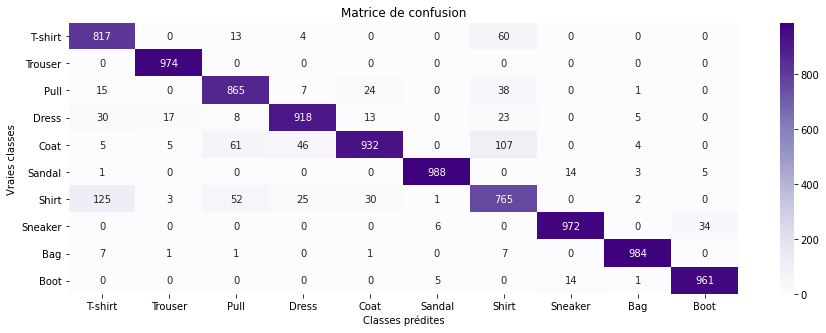

In [81]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [82]:
compare_models(df)


<div class='alert alert-info' role='alert'><p>
    
Ce mod√®le est aussi performant que le mod√®le CNN par d√©faut. Il obtient cependant une pr√©cision plus faible. Encore une fois, les diff√©rences sont tr√®s faibles. De m√™me, avec cette architecture, les pr√©dictions concernant les chemises (*Shirt*) sont √©galement celles qui posent le plus de difficult√©s.
    
</p></div>

# Conclusion g√©n√©rale

On peut conclure que le mod√®le sugg√©r√© par l'√©nonc√© est tr√®s bien param√©tr√©. On obtient des scores tr√®s √©lev√©s sur le jeu de test :
- Pr√©cision de **92%**
- Perte de **0.26**

En modifiant les hyperparam√®tres des mod√®les, on peut obtenir quelques variations dans les scores de pr√©cision et de perte. Ces variations sont tr√®s faibles et ne permettent pas d'am√©liorer le mod√®le de mani√®re significative. On peut m√™me se demander si ces am√©liorations sont vraiment dues au param√©trage, ou bien si elles sont dues √† l'al√©a. 

En modifiant l'architecture ou en effectuant de l'augmentation des donn√©es (*Data augmentation*), on peut parfois mieux minimiser notre perte. 

Quelles que soient les mod√®les, on observe toujours des scores plus faibles quand il s'agit de chemises (*Shirt*), tant au niveau du score de pr√©cision que du score de rappel. Ainsi, le score F1 est globalement plus faible pour la classe des chemises. On pourrait expliquer cela na√Øvement par le fait que pour identifier une chemise, on a besoin d'observer certains d√©tails de l'image (comme le col) alors que pour les autres classes de v√™tement, observer leur forme permet de conclure.

Enfin, les architectures de type CNN semblent plus adapt√©es que les FFNN.

# Extension : pr√©dictions √† partir d'images quelconques

En guise d'extension, on peut se demander si le jeu de donn√©es `fashion_mnist` est repr√©sentatif de la r√©alit√©. On va essayer de pr√©dire la classe de v√™tement √† partir d'images quelconque mais similaire. 

On va utiliser le mod√®le CNN par d√©faut sugg√©r√© en √©nonc√©. 

In [83]:
def load_image(file) :
    """
    
    Load an image
    
    Parameters
    ----------
    file : 
        name of the file of the image
        
    Returns
    ----------
    the image
    
    """
    if (file.lower().endswith(('.png','jpg','jpeg'))) : 
        path = IMG_PATH +"/"+ file
        image = Image.open(path)
        return image
    
def convert_to_fashion_mnist_format(image) :
    """
    
    Convert an image in the same format as fashion_mnist
    
    Parameters
    ----------
    image : 
        the image
        
    Returns
    ----------
    the converted image
    
    """
    image = image.convert('L')
    image = image.resize( (28,28) )
    matrix = np.ones((28,28))*255
    image = matrix - image
    image = np.asarray(image)
    return image

def built_test(model) :
    """
    
    Test predictions from images 
    
    Parameters
    ----------
    model : 
        name of the model
        
    """
    for file in os.listdir(IMG_PATH):
        img = load_image(file)
        print_title("Image avant conversion")
        plt.imshow(img)
        plt.show()
        img = convert_to_fashion_mnist_format(img)
        img = img.reshape(1,28,28,1)
        y_pred = model.predict(img)
        show_prediction(y_pred, 0, X_test=[img])
        print(78*"_")


## Mod√®le par d√©faut sans donn√©es augment√©es

On va tester le mod√®le par d√©faut, entra√Æn√© sans *Data Augmentation*.


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



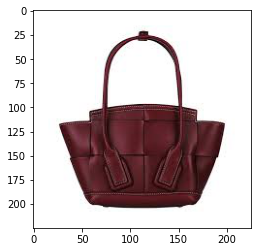


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



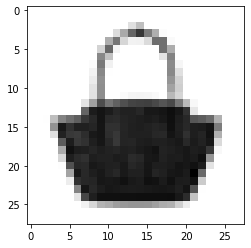


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilit√© par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 1.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pr√©diction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

BAG
______________________________________________________________________________

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



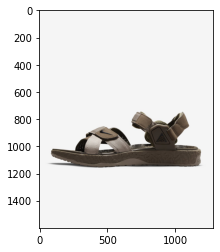


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



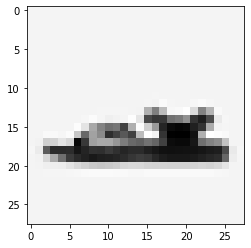


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilit√© par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 1.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pr√©diction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

BAG
______________________________________________________________________________

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



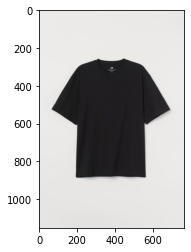


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



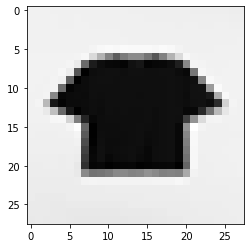


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilit√© par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 1.0000
Sneaker : 0.0000
Bag : 0.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pr√©diction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

SHIRT
______________________________________________________________________________

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



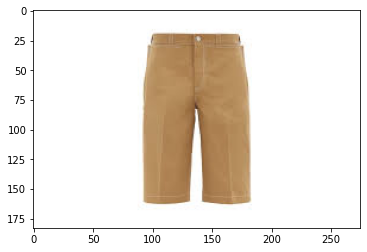


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



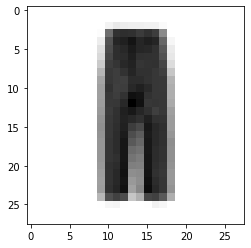


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilit√© par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 1.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 0.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pr√©diction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

TROUSER
______________________________________________________________________________


In [84]:
model = my_load_model_full("cnn")[0]
built_test(model)

## Mod√®le par d√©faut avec donn√©es augment√©es

On va tester le mod√®le par d√©faut, entra√Æn√© avec les donn√©es augment√©es (*Data Augmentation*).


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



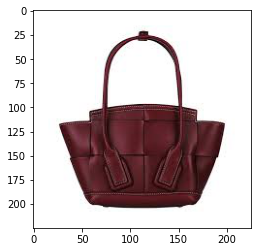


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



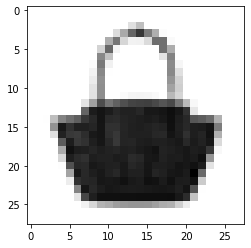


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilit√© par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 1.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pr√©diction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

BAG
______________________________________________________________________________

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



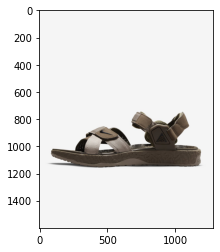


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



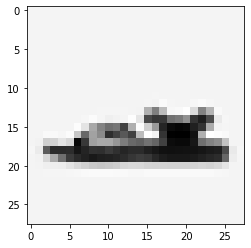


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilit√© par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 1.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 0.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pr√©diction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

SANDAL
______________________________________________________________________________

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



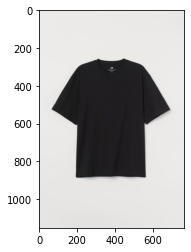


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



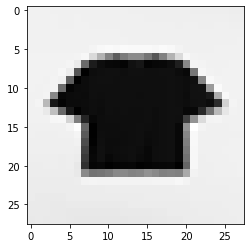


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilit√© par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

T-shirt : 1.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 0.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pr√©diction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

T-SHIRT
______________________________________________________________________________

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



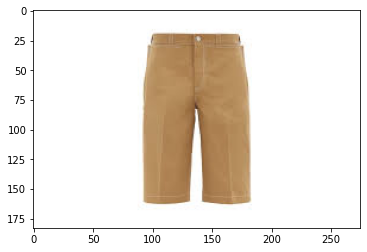


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+



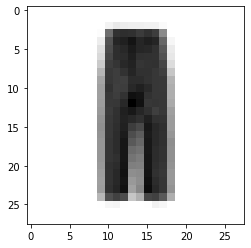


+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilit√© par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 1.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 0.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¬¶~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pr√©diction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¬¶
+---------------------------------------------------------------------------+

TROUSER
______________________________________________________________________________


In [85]:
model = my_load_model_full("data_augmented")[0]
built_test(model)

<div class='alert alert-info' role='alert'><p>
    
Dans ces exemples, peut voir que le mod√®le par d√©faut, sans *Data augmentation*, se trompe parfois. Alors que le mod√®le entra√Æn√© sur les donn√©es augment√©es ne se trompe pas.
Ajouter du bruit aux images d'entra√Ænement permet sans doute de mieux repr√©senter les images bruit√©es que l'on peut trouver dans la r√©alit√©. 
    
</p></div>

<hr>

<div class="alert alert-warning" role="alert">

# Annexe : √ânonc√© du devoir

**Homework 1**

**A fashionable use case : clothing classification with `fashion-mnist`**

- Load data with `fashion_mnist.load_data()` 
- There is no validation set, only a train and test set. 
- The labels correspond to the following things

| Label number | Label name  |
|--------------|-------------|
| 0	           | T-shirt/top |
| 1	           | Trouser     |
| 2	           | Pullover    |
| 3	           | Dress       |
| 4	           | Coat        |
| 5	           | Sandal      |
| 6	           | Shirt       |
| 7	           | Sneaker     |
| 8	           | Bag         |
| 9	           | Ankle boot  |

**Your job**

- Try to understand the data, visualize it, like we did before with MNIST and noMNIST
- Create a neural network, using the ideas from before, that classify accurately the clothes on the test set
- You will need to build a validation set from the train set in order to tune hyperparameters

**We want to see the following things**

- Some learning curves (training) and the accuracy obtained on the test set for the architecture you considered
- A discussion about the impact of the hyperparameters on the accuracy (size of the kernels, number of kernels, number of layers, etc.) 
- A clear comparison between your solutions (a table, or plots comparing the results obtained with different hyper-parameters and different architectures)
- An explanation of what kind of clothes are hard to distinguish and why (some visual explanation)
- You'll get a good grade if you reach a good accuracy **and** if your notebook is clean, with clear graphs and explanations of what you did **and** if you did serious comparisons between different architectures
- You can do everything on your laptop, but it might be a good idea to use google `colab` (https://colab.research.google.com/) to get free access to a GPU
- You will send your notebook **containing** the results (**WE WON'T RUN YOUR NOTEBOOK**), namely with the graphs and results that you want to show, as a **unique** jupyter notebook file (`.ipynb` extension). We won't open any other supplementary file.

**Send your work using the following google form :**

- https://forms.gle/G3Rwfcuj3MZfgXhr8

(you will need to create a google account if you don't have one).

**Example of architecture**

As a start, you can use the following architecture (but you can and will change it) :

- Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Convolutional layer with 128 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Convolutional layer with 256 filters and 3 * 3 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Dense layer with 256 units
- Dropout with probability 0.5
- Dense output layer with softmax activation
    

</div>
